In [1]:
import gym
import numpy as np

In [2]:
env = gym.make('Acrobot-v1')

[2017-07-31 17:14:31,242] Making new env: Acrobot-v1


In [13]:
env.reset()
for i in range(100):
    env.render()
    state,reward,done,info = env.step(0)
    #print(state,reward,done,info)
    if done:
        print('finished' + str(i))
        env.reset()
    
env.render(close=True)

In [141]:
env.reset()
actions = []
for i in range(1000):
    action = env.action_space.sample()
    actions.append(action)
    
print(np.max(actions),np.min(actions))
print(actions)

2 0
[1, 1, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 0, 0, 2, 2, 1, 0, 0, 0, 1, 2, 0, 2, 1, 2, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 2, 0, 0, 1, 2, 2, 1, 2, 1, 1, 0, 0, 0, 2, 1, 2, 1, 2, 0, 1, 2, 1, 1, 0, 1, 2, 1, 0, 2, 0, 1, 1, 0, 0, 1, 0, 0, 2, 1, 2, 1, 2, 0, 1, 1, 2, 0, 1, 0, 1, 0, 1, 0, 1, 2, 0, 0, 2, 1, 1, 2, 1, 2, 2, 0, 1, 2, 1, 0, 2, 1, 1, 1, 2, 0, 0, 1, 1, 1, 1, 2, 2, 1, 0, 1, 0, 1, 2, 1, 2, 0, 1, 1, 1, 1, 1, 0, 1, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 2, 0, 2, 1, 0, 2, 0, 1, 1, 1, 2, 0, 2, 0, 1, 1, 0, 0, 0, 2, 2, 1, 2, 2, 2, 1, 0, 2, 2, 0, 2, 1, 1, 1, 0, 0, 0, 1, 2, 0, 2, 2, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 2, 1, 1, 1, 2, 1, 1, 1, 0, 0, 2, 0, 2, 1, 0, 1, 2, 0, 2, 0, 2, 1, 2, 1, 1, 0, 2, 2, 1, 2, 2, 2, 1, 0, 0, 2, 2, 2, 0, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 0, 0, 2, 0, 1, 0, 2, 2, 1, 2, 1, 0, 0, 0, 1, 0, 0, 1, 1, 2, 0, 0, 1, 0, 2, 0, 2, 1, 0, 2, 0, 0, 1, 0, 0, 1, 0, 2, 0, 1, 0, 1, 2, 2, 0, 1, 0, 0, 2, 2, 2, 1, 2, 2, 1, 1, 1, 2,

In [5]:
print(env.action_space)

Discrete(3)


In [11]:
print(env.action_space.n)

3


In [ ]:
#https://github.com/openai/gym/blob/master/gym/envs/classic_control/acrobot.py
#actions are -1, 0, 1 for torque between the pendulum joints
#state space is the angles between the the two joints and the first joint (sin and cos of each) and 2 things for angular velocity
#rewards are -1 until it is terminal, at that point reward is 0

#appears that it accidentally works up enough momentum every 500 steps

#some ideas I can try:
#want to do the td 0 Q,A from chapter 6 of Sutton's RL book
#bellman equation and Qtable (like I did for cartpole)
#mc
#td learning (might be hard because state size is so large)
#I don't think dp or the bandit methods make sense in this context

In [33]:
#hyperparameters
episodes = 100000
e_max = 1.
e_min = 0.05
e_decay = (e_max - e_min)/episodes #just doing it linearly 
max_steps = 500
alpha = 0.05
round_place = 10
gamma = 0.99

In [ ]:
def get_max_state_action(q_table,actions,state,round_place):
    max_state = -1.
    max_action = actions[0]
    state = state[4:]
    state = np.round(state*round_place)
    state_tuple = totuple(state)
    for i in actions:
        temp_value = q_table.get((i,state_tuple),-1.)
        if temp_value > max_state:
            max_state = temp_value
            max_action = i
    return max_state,max_action

def add_to_q(q_table,action,state,value,round_place):
    state = state[4:]
    state = np.round(state*round_place)
    state_tuple = totuple(state)
    q_table[(action,state_tuple)] = value
    
def get_q_value(q_table,action,state,round_place):
    state = state[4:]
    state = np.round(state*round_place)
    #print(state)
    state_tuple = totuple(state)
    #print(state_tuple)
    return q_table.get((action,state_tuple),-1.)

def totuple(a):
    try:
        return tuple(totuple(i) for i in a)
    except TypeError:
        return a

In [35]:
action_space = [0,1,2]    
Q = {}
steps = 0
#step_array = []
recent_step_array = []

for i in range(episodes):#range(10):#
    state = env.reset()
    steps += 1
    for j in range(max_steps):
        
        explore_prob = e_max - e_decay*steps
        if np.random.rand() <= explore_prob:
            #choose randomly
            action = env.action_space.sample()
        else:
            _,action = get_max_state_action(Q,action_space,state,round_place)
            
        next_state,reward,done,_ = env.step(action)
        
        if done:
            #print(reward)
            #break
            q_value = get_q_value(Q,action,state,round_place)
            value = q_value + alpha*(reward + 0. - q_value)
            add_to_q(Q,action,state,value,round_place)
            #step_array.append(j)
            recent_step_array.append(j)
            if i % 50 == 0:
                print("episode {}".format(i), " steps: {}".format(j), 
                      " avg. steps {}".format(np.mean(recent_step_array)), " e: {} ".format(explore_prob))
                recent_step_array = []
            break
        else:
            max_state,_ = get_max_state_action(Q,action_space,state,round_place)
            #print(max_state)
            q_value = get_q_value(Q,action,state,round_place)
            value = q_value + alpha*(reward + gamma*max_state - q_value)
            add_to_q(Q,action,state,value,round_place)
            state = next_state

    

episode 0  steps: 499  avg. steps 499.0  e: 0.9999905 
episode 50  steps: 297  avg. steps 494.96  e: 0.9995155 
episode 100  steps: 499  avg. steps 498.72  e: 0.9990405 
episode 150  steps: 499  avg. steps 497.74  e: 0.9985655 
episode 200  steps: 375  avg. steps 496.52  e: 0.9980905 
episode 250  steps: 499  avg. steps 496.82  e: 0.9976155 
episode 300  steps: 499  avg. steps 498.44  e: 0.9971405 
episode 350  steps: 499  avg. steps 499.0  e: 0.9966655 
episode 400  steps: 499  avg. steps 499.0  e: 0.9961905 
episode 450  steps: 499  avg. steps 497.94  e: 0.9957155 
episode 500  steps: 499  avg. steps 499.0  e: 0.9952405 
episode 550  steps: 499  avg. steps 499.0  e: 0.9947655 
episode 600  steps: 499  avg. steps 499.0  e: 0.9942905 
episode 650  steps: 499  avg. steps 497.6  e: 0.9938155 
episode 700  steps: 499  avg. steps 498.8  e: 0.9933405 
episode 750  steps: 499  avg. steps 499.0  e: 0.9928655 
episode 800  steps: 499  avg. steps 497.48  e: 0.9923905 
episode 850  steps: 499  a

episode 7050  steps: 499  avg. steps 497.78  e: 0.9330155 
episode 7100  steps: 499  avg. steps 498.2  e: 0.9325405 
episode 7150  steps: 499  avg. steps 496.02  e: 0.9320655 
episode 7200  steps: 499  avg. steps 499.0  e: 0.9315905 
episode 7250  steps: 499  avg. steps 496.76  e: 0.9311155 
episode 7300  steps: 499  avg. steps 498.18  e: 0.9306405 
episode 7350  steps: 499  avg. steps 499.0  e: 0.9301655 
episode 7400  steps: 499  avg. steps 497.08  e: 0.9296905 
episode 7450  steps: 499  avg. steps 496.7  e: 0.9292155 
episode 7500  steps: 499  avg. steps 499.0  e: 0.9287405 
episode 7550  steps: 499  avg. steps 499.0  e: 0.9282655 
episode 7600  steps: 499  avg. steps 493.48  e: 0.9277905 
episode 7650  steps: 499  avg. steps 499.0  e: 0.9273155 
episode 7700  steps: 499  avg. steps 499.0  e: 0.9268405 
episode 7750  steps: 499  avg. steps 497.14  e: 0.9263655 
episode 7800  steps: 499  avg. steps 494.24  e: 0.9258905 
episode 7850  steps: 499  avg. steps 499.0  e: 0.925415500000000

episode 13850  steps: 429  avg. steps 497.26  e: 0.8684155 
episode 13900  steps: 496  avg. steps 490.38  e: 0.8679405 
episode 13950  steps: 499  avg. steps 495.64  e: 0.8674655 
episode 14000  steps: 428  avg. steps 494.78  e: 0.8669905 
episode 14050  steps: 499  avg. steps 496.8  e: 0.8665155 
episode 14100  steps: 499  avg. steps 495.66  e: 0.8660405 
episode 14150  steps: 499  avg. steps 494.72  e: 0.8655655 
episode 14200  steps: 499  avg. steps 492.1  e: 0.8650905 
episode 14250  steps: 499  avg. steps 497.5  e: 0.8646155 
episode 14300  steps: 499  avg. steps 496.9  e: 0.8641405 
episode 14350  steps: 499  avg. steps 498.22  e: 0.8636655 
episode 14400  steps: 499  avg. steps 499.0  e: 0.8631905 
episode 14450  steps: 499  avg. steps 493.92  e: 0.8627155 
episode 14500  steps: 499  avg. steps 495.34  e: 0.8622405 
episode 14550  steps: 499  avg. steps 497.9  e: 0.8617655 
episode 14600  steps: 499  avg. steps 494.9  e: 0.8612905 
episode 14650  steps: 499  avg. steps 496.88  e

episode 20700  steps: 499  avg. steps 494.36  e: 0.8033405 
episode 20750  steps: 499  avg. steps 497.9  e: 0.8028655 
episode 20800  steps: 499  avg. steps 492.08  e: 0.8023905 
episode 20850  steps: 499  avg. steps 499.0  e: 0.8019155 
episode 20900  steps: 499  avg. steps 494.8  e: 0.8014405 
episode 20950  steps: 499  avg. steps 489.58  e: 0.8009655 
episode 21000  steps: 499  avg. steps 492.54  e: 0.8004905 
episode 21050  steps: 499  avg. steps 495.98  e: 0.8000155 
episode 21100  steps: 499  avg. steps 496.68  e: 0.7995405 
episode 21150  steps: 499  avg. steps 491.8  e: 0.7990655 
episode 21200  steps: 499  avg. steps 497.78  e: 0.7985905 
episode 21250  steps: 499  avg. steps 495.68  e: 0.7981155 
episode 21300  steps: 499  avg. steps 492.42  e: 0.7976405 
episode 21350  steps: 290  avg. steps 483.92  e: 0.7971655 
episode 21400  steps: 499  avg. steps 499.0  e: 0.7966905 
episode 21450  steps: 499  avg. steps 492.68  e: 0.7962155 
episode 21500  steps: 499  avg. steps 495.66 

episode 27300  steps: 499  avg. steps 497.72  e: 0.7406405 
episode 27350  steps: 499  avg. steps 494.0  e: 0.7401655 
episode 27400  steps: 499  avg. steps 499.0  e: 0.7396905 
episode 27450  steps: 443  avg. steps 488.78  e: 0.7392155 
episode 27500  steps: 499  avg. steps 490.94  e: 0.7387405 
episode 27550  steps: 499  avg. steps 489.46  e: 0.7382655 
episode 27600  steps: 499  avg. steps 496.04  e: 0.7377905 
episode 27650  steps: 499  avg. steps 493.96  e: 0.7373155 
episode 27700  steps: 499  avg. steps 495.3  e: 0.7368405 
episode 27750  steps: 499  avg. steps 494.36  e: 0.7363655 
episode 27800  steps: 499  avg. steps 496.14  e: 0.7358905 
episode 27850  steps: 499  avg. steps 497.14  e: 0.7354155 
episode 27900  steps: 499  avg. steps 488.44  e: 0.7349405 
episode 27950  steps: 499  avg. steps 492.38  e: 0.7344655 
episode 28000  steps: 499  avg. steps 498.18  e: 0.7339905 
episode 28050  steps: 499  avg. steps 493.68  e: 0.7335155 
episode 28100  steps: 499  avg. steps 494.2

episode 33950  steps: 499  avg. steps 491.78  e: 0.6774655 
episode 34000  steps: 499  avg. steps 496.46  e: 0.6769905 
episode 34050  steps: 499  avg. steps 498.02  e: 0.6765155 
episode 34100  steps: 499  avg. steps 496.48  e: 0.6760405 
episode 34150  steps: 499  avg. steps 492.64  e: 0.6755655 
episode 34200  steps: 476  avg. steps 496.84  e: 0.6750905 
episode 34250  steps: 499  avg. steps 494.56  e: 0.6746155 
episode 34300  steps: 454  avg. steps 486.84  e: 0.6741405 
episode 34350  steps: 499  avg. steps 489.12  e: 0.6736655 
episode 34400  steps: 499  avg. steps 492.14  e: 0.6731905 
episode 34450  steps: 499  avg. steps 497.2  e: 0.6727155 
episode 34500  steps: 499  avg. steps 498.32  e: 0.6722405 
episode 34550  steps: 499  avg. steps 492.6  e: 0.6717655 
episode 34600  steps: 499  avg. steps 489.12  e: 0.6712905 
episode 34650  steps: 499  avg. steps 495.26  e: 0.6708155 
episode 34700  steps: 499  avg. steps 491.9  e: 0.6703405 
episode 34750  steps: 499  avg. steps 487.6

episode 40450  steps: 499  avg. steps 493.4  e: 0.6157155000000001 
episode 40500  steps: 499  avg. steps 482.34  e: 0.6152405000000001 
episode 40550  steps: 499  avg. steps 490.94  e: 0.6147655000000001 
episode 40600  steps: 499  avg. steps 492.42  e: 0.6142905000000001 
episode 40650  steps: 499  avg. steps 494.84  e: 0.6138155000000001 
episode 40700  steps: 499  avg. steps 495.58  e: 0.6133405000000001 
episode 40750  steps: 499  avg. steps 489.38  e: 0.6128655000000001 
episode 40800  steps: 499  avg. steps 487.54  e: 0.6123905000000001 
episode 40850  steps: 499  avg. steps 494.06  e: 0.6119155000000001 
episode 40900  steps: 499  avg. steps 491.68  e: 0.6114405 
episode 40950  steps: 499  avg. steps 493.88  e: 0.6109655 
episode 41000  steps: 499  avg. steps 485.52  e: 0.6104905 
episode 41050  steps: 499  avg. steps 491.3  e: 0.6100155 
episode 41100  steps: 499  avg. steps 491.1  e: 0.6095405 
episode 41150  steps: 499  avg. steps 496.72  e: 0.6090655 
episode 41200  steps: 

episode 47000  steps: 499  avg. steps 489.78  e: 0.5534905000000001 
episode 47050  steps: 499  avg. steps 497.04  e: 0.5530155000000001 
episode 47100  steps: 499  avg. steps 490.42  e: 0.5525405000000001 
episode 47150  steps: 499  avg. steps 490.38  e: 0.5520655000000001 
episode 47200  steps: 499  avg. steps 488.54  e: 0.5515905000000001 
episode 47250  steps: 499  avg. steps 491.66  e: 0.5511155000000001 
episode 47300  steps: 499  avg. steps 498.66  e: 0.5506405000000001 
episode 47350  steps: 437  avg. steps 494.8  e: 0.5501655000000001 
episode 47400  steps: 499  avg. steps 497.36  e: 0.5496905000000001 
episode 47450  steps: 499  avg. steps 493.78  e: 0.5492155000000001 
episode 47500  steps: 499  avg. steps 492.44  e: 0.5487405000000001 
episode 47550  steps: 499  avg. steps 489.12  e: 0.5482655000000001 
episode 47600  steps: 499  avg. steps 490.2  e: 0.5477905000000001 
episode 47650  steps: 499  avg. steps 479.96  e: 0.5473155000000001 
episode 47700  steps: 499  avg. step

episode 53400  steps: 499  avg. steps 491.9  e: 0.49269050000000003 
episode 53450  steps: 469  avg. steps 492.7  e: 0.49221550000000003 
episode 53500  steps: 499  avg. steps 490.78  e: 0.4917405 
episode 53550  steps: 499  avg. steps 497.26  e: 0.4912655 
episode 53600  steps: 499  avg. steps 490.84  e: 0.4907905 
episode 53650  steps: 499  avg. steps 483.7  e: 0.4903155 
episode 53700  steps: 397  avg. steps 491.28  e: 0.4898405 
episode 53750  steps: 499  avg. steps 490.78  e: 0.4893655 
episode 53800  steps: 499  avg. steps 496.36  e: 0.4888905000000001 
episode 53850  steps: 499  avg. steps 494.46  e: 0.4884155000000001 
episode 53900  steps: 499  avg. steps 479.72  e: 0.4879405000000001 
episode 53950  steps: 499  avg. steps 491.04  e: 0.4874655000000001 
episode 54000  steps: 499  avg. steps 490.48  e: 0.4869905000000001 
episode 54050  steps: 499  avg. steps 493.72  e: 0.4865155000000001 
episode 54100  steps: 499  avg. steps 491.6  e: 0.4860405000000001 
episode 54150  steps:

episode 59500  steps: 499  avg. steps 494.06  e: 0.4347405000000001 
episode 59550  steps: 499  avg. steps 485.94  e: 0.4342655000000001 
episode 59600  steps: 499  avg. steps 492.38  e: 0.4337905000000001 
episode 59650  steps: 499  avg. steps 485.24  e: 0.4333155000000001 
episode 59700  steps: 499  avg. steps 493.62  e: 0.4328405000000001 
episode 59750  steps: 499  avg. steps 487.34  e: 0.43236550000000007 
episode 59800  steps: 499  avg. steps 496.94  e: 0.43189050000000007 
episode 59850  steps: 499  avg. steps 488.86  e: 0.43141550000000006 
episode 59900  steps: 499  avg. steps 490.9  e: 0.43094050000000006 
episode 59950  steps: 499  avg. steps 491.56  e: 0.43046550000000006 
episode 60000  steps: 499  avg. steps 485.4  e: 0.42999050000000005 
episode 60050  steps: 499  avg. steps 488.84  e: 0.42951550000000005 
episode 60100  steps: 499  avg. steps 492.76  e: 0.42904050000000005 
episode 60150  steps: 499  avg. steps 494.26  e: 0.42856550000000004 
episode 60200  steps: 499  

episode 65500  steps: 499  avg. steps 496.08  e: 0.37774050000000003 
episode 65550  steps: 499  avg. steps 482.38  e: 0.37726550000000003 
episode 65600  steps: 499  avg. steps 497.12  e: 0.37679050000000003 
episode 65650  steps: 499  avg. steps 493.68  e: 0.3763155 
episode 65700  steps: 499  avg. steps 492.74  e: 0.3758405 
episode 65750  steps: 499  avg. steps 498.48  e: 0.37536550000000013 
episode 65800  steps: 499  avg. steps 494.14  e: 0.3748905000000001 
episode 65850  steps: 499  avg. steps 484.68  e: 0.3744155000000001 
episode 65900  steps: 499  avg. steps 490.82  e: 0.3739405000000001 
episode 65950  steps: 499  avg. steps 494.46  e: 0.3734655000000001 
episode 66000  steps: 499  avg. steps 491.56  e: 0.3729905000000001 
episode 66050  steps: 499  avg. steps 496.46  e: 0.3725155000000001 
episode 66100  steps: 499  avg. steps 496.04  e: 0.3720405000000001 
episode 66150  steps: 499  avg. steps 495.72  e: 0.3715655000000001 
episode 66200  steps: 499  avg. steps 498.18  e:

episode 71550  steps: 499  avg. steps 494.3  e: 0.3202655000000001 
episode 71600  steps: 499  avg. steps 498.36  e: 0.3197905000000001 
episode 71650  steps: 499  avg. steps 494.3  e: 0.3193155000000001 
episode 71700  steps: 499  avg. steps 494.46  e: 0.3188405000000001 
episode 71750  steps: 499  avg. steps 493.08  e: 0.3183655000000001 
episode 71800  steps: 499  avg. steps 498.88  e: 0.3178905000000001 
episode 71850  steps: 499  avg. steps 495.08  e: 0.3174155000000001 
episode 71900  steps: 462  avg. steps 492.22  e: 0.31694050000000007 
episode 71950  steps: 499  avg. steps 493.38  e: 0.31646550000000007 
episode 72000  steps: 499  avg. steps 494.82  e: 0.31599050000000006 
episode 72050  steps: 499  avg. steps 492.94  e: 0.31551550000000006 
episode 72100  steps: 499  avg. steps 493.76  e: 0.31504050000000006 
episode 72150  steps: 499  avg. steps 497.56  e: 0.31456550000000005 
episode 72200  steps: 499  avg. steps 493.26  e: 0.31409050000000005 
episode 72250  steps: 385  av

episode 77500  steps: 499  avg. steps 486.74  e: 0.26374050000000004 
episode 77550  steps: 499  avg. steps 492.7  e: 0.26326550000000004 
episode 77600  steps: 499  avg. steps 495.14  e: 0.26279050000000004 
episode 77650  steps: 499  avg. steps 496.16  e: 0.26231550000000015 
episode 77700  steps: 499  avg. steps 494.7  e: 0.26184050000000014 
episode 77750  steps: 499  avg. steps 490.42  e: 0.26136550000000014 
episode 77800  steps: 499  avg. steps 498.3  e: 0.26089050000000014 
episode 77850  steps: 499  avg. steps 499.0  e: 0.26041550000000013 
episode 77900  steps: 499  avg. steps 494.52  e: 0.25994050000000013 
episode 77950  steps: 499  avg. steps 498.46  e: 0.2594655000000001 
episode 78000  steps: 499  avg. steps 495.0  e: 0.2589905000000001 
episode 78050  steps: 499  avg. steps 496.06  e: 0.2585155000000001 
episode 78100  steps: 499  avg. steps 496.02  e: 0.2580405000000001 
episode 78150  steps: 499  avg. steps 496.88  e: 0.2575655000000001 
episode 78200  steps: 499  avg

episode 83550  steps: 499  avg. steps 499.0  e: 0.2062655000000001 
episode 83600  steps: 499  avg. steps 499.0  e: 0.2057905000000001 
episode 83650  steps: 499  avg. steps 496.68  e: 0.2053155000000001 
episode 83700  steps: 499  avg. steps 497.9  e: 0.2048405000000001 
episode 83750  steps: 499  avg. steps 499.0  e: 0.2043655000000001 
episode 83800  steps: 499  avg. steps 496.96  e: 0.20389050000000009 
episode 83850  steps: 333  avg. steps 493.26  e: 0.20341550000000008 
episode 83900  steps: 499  avg. steps 499.0  e: 0.20294050000000008 
episode 83950  steps: 499  avg. steps 494.98  e: 0.20246550000000008 
episode 84000  steps: 499  avg. steps 498.68  e: 0.20199050000000007 
episode 84050  steps: 499  avg. steps 498.5  e: 0.20151550000000007 
episode 84100  steps: 499  avg. steps 498.12  e: 0.20104050000000007 
episode 84150  steps: 499  avg. steps 491.74  e: 0.20056550000000006 
episode 84200  steps: 499  avg. steps 499.0  e: 0.20009050000000006 
episode 84250  steps: 499  avg. 

episode 89500  steps: 499  avg. steps 494.9  e: 0.14974050000000005 
episode 89550  steps: 499  avg. steps 499.0  e: 0.14926550000000005 
episode 89600  steps: 499  avg. steps 499.0  e: 0.14879050000000016 
episode 89650  steps: 499  avg. steps 499.0  e: 0.14831550000000016 
episode 89700  steps: 499  avg. steps 499.0  e: 0.14784050000000015 
episode 89750  steps: 499  avg. steps 499.0  e: 0.14736550000000015 
episode 89800  steps: 499  avg. steps 499.0  e: 0.14689050000000015 
episode 89850  steps: 499  avg. steps 498.62  e: 0.14641550000000014 
episode 89900  steps: 499  avg. steps 499.0  e: 0.14594050000000014 
episode 89950  steps: 499  avg. steps 499.0  e: 0.14546550000000014 
episode 90000  steps: 499  avg. steps 499.0  e: 0.14499050000000013 
episode 90050  steps: 499  avg. steps 499.0  e: 0.14451550000000013 
episode 90100  steps: 499  avg. steps 499.0  e: 0.14404050000000013 
episode 90150  steps: 499  avg. steps 498.52  e: 0.14356550000000012 
episode 90200  steps: 499  avg. 

episode 95650  steps: 499  avg. steps 499.0  e: 0.0913155000000001 
episode 95700  steps: 499  avg. steps 499.0  e: 0.0908405000000001 
episode 95750  steps: 499  avg. steps 499.0  e: 0.0903655000000001 
episode 95800  steps: 499  avg. steps 499.0  e: 0.0898905000000001 
episode 95850  steps: 499  avg. steps 499.0  e: 0.08941550000000009 
episode 95900  steps: 499  avg. steps 499.0  e: 0.08894050000000009 
episode 95950  steps: 499  avg. steps 498.16  e: 0.08846550000000009 
episode 96000  steps: 499  avg. steps 499.0  e: 0.08799050000000008 
episode 96050  steps: 499  avg. steps 499.0  e: 0.08751550000000008 
episode 96100  steps: 499  avg. steps 499.0  e: 0.08704050000000008 
episode 96150  steps: 499  avg. steps 499.0  e: 0.08656550000000007 
episode 96200  steps: 499  avg. steps 499.0  e: 0.08609050000000007 
episode 96250  steps: 499  avg. steps 499.0  e: 0.08561550000000007 
episode 96300  steps: 499  avg. steps 499.0  e: 0.08514050000000006 
episode 96350  steps: 499  avg. steps

In [36]:
#100000 episodes, round_place = 100, length of Q was 46719921
print(len(Q))
#print(Q)

67698


In [37]:
zbreak = 0
for value in Q:
    zbreak += 1
    if zbreak > 10:
        break
    print(value)
    #break

(1, (4.0, -25.0))
(1, (-4.0, 31.0))
(1, (13.0, 94.0))
(1, (-12.0, 12.0))
(2, (2.0, -51.0))
(0, (-52.0, 88.0))
(2, (-50.0, 59.0))
(2, (51.0, -79.0))
(0, (-8.0, -40.0))
(1, (-0.0, 104.0))


In [44]:
#range of velocity values when doing last two states, rounded to 10
vel1 = []
vel2 = []
for key,value in Q.items():
    vel1.append(key[1][0])
    vel2.append(key[1][1])
    #break
#print(vel1,vel2)

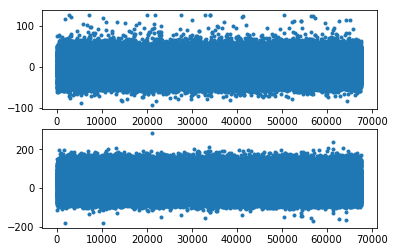

In [45]:
import matplotlib.pyplot as plt
plt.subplot(211)
plt.plot(vel1,'.')
plt.subplot(212)
plt.plot(vel2,'.')
plt.show()

## Notes
* Failed on 100000 episodes, rounding to 10. Still like 10 million states. Hardly reaches termination successfully and TD(0) only looks ahead one state so hard for correct answers to back prop. Also failed on rounding 100. State space is too massive. Failed at only looking at the last two values of the state and rounding to 10 (70,000 states)
* ideas: smaller state space, more reps, different decay rate (expolit more), break Q table up into bins, remove one of the actions
* try forward view Sarsa(lambda)
* test some of the Q table values maybe... make sure they are updating correctly
* maybe bin the states: 20,20,20,20,10,10
* range of states 0:3 is cos and sin of angles so -1 to 1. Range of state 4: is -100 to 100 and -200 to 200
* tried bin states, Q learning, 100000 episodes and that failed. 148060 states. Fully trained example couldn't break out of a narrow range. maybe binned too aggressively

### New Approach
* do Sarsa lambda of 0.99
* bin the states: 20,20,20,20,10,10. can try to find a math approximation for the first 4 states. like negative/pos, then round towards nearest .1 increment
* test some of my Q table values, make sure I'm Sarsa'ing correctly

In [3]:
def bin_states(state,angle_bins):
    
    for i in range(6):
        if i < 4:
            state[i] = np.round(state[i] * angle_bins,0) 
        elif i == 4:
            temp_int = np.round(state[i],0)
            if temp_int < -9:
                temp_int = -9
            elif temp_int > 9:
                temp_int = 9
            state[i] = temp_int
        elif i == 5:
            temp_int = np.round(state[i]/2,0)
            if temp_int < -9:
                temp_int = -9
            elif temp_int > 9:
                temp_int = 9
            state[i] = temp_int
    return state        

In [4]:
def get_max_state_action(q_table,actions,state,round_place):
    max_state = -1.
    max_action = actions[0]
#     state = state[4:]
#     state = np.round(state*round_place)
    state_tuple = totuple(state)
    tied_actions = []
    for i in actions:
        temp_value = q_table.get((i,state_tuple),-1.)
        if temp_value > max_state:
            max_state = temp_value
            max_action = i
            tied_actions = []
            tied_actions.append(i)
        elif temp_value == max_state:
            tied_actions.append(i)
          
    if len(tied_actions) > 1:
        max_action = tied_actions[np.random.randint(0,len(tied_actions))]

    return max_state,max_action

def add_to_q(q_table,action,state,value,round_place):
#     state = state[4:]
#     state = np.round(state*round_place)
    state_tuple = totuple(state)
    #print((action,state_tuple))
    q_table[(action,state_tuple)] = value
    
def get_q_value(q_table,action,state,round_place):
    #state = state[4:]
    #state = np.round(state*round_place)
    #print(state)
    #state = bin_states(state,5)
    state_tuple = totuple(state)
    #print(state_tuple)
    #print((action,state_tuple))
    return q_table.get((action,state_tuple),-1.)

def totuple(a):
    try:
        return tuple(totuple(i) for i in a)
    except TypeError:
        return a

In [5]:
#hyperparameters
episodes = 100000
report_steps = 100
e_max = 1.
e_min = 0.05
e_decay = (e_max - e_min)/episodes #just doing it linearly 
max_steps = 500
alpha = 0.3
alpha_decay = 0.8
alpha_decay_mod = episodes/10
round_place = 10
gamma = 0.99


In [6]:
action_space = [0,1,2]
Q = {}
steps = 0
#step_array = []
recent_step_array = []

for i in range(episodes):#range(10):#
    state = env.reset()
    state = bin_states(state,5)
    steps += 1
    for j in range(max_steps):
        
        explore_prob = e_max - e_decay*steps
        if np.random.rand() <= explore_prob:
            #choose randomly
            action = env.action_space.sample()
        else:
            _,action = get_max_state_action(Q,action_space,state,round_place)
            
        next_state,reward,done,_ = env.step(action)
        next_state = bin_states(next_state,5)
        
        if done:
            #print(reward, max_steps)
            #break
            #either done because it reaches max_steps or because it finished
            q_value = get_q_value(Q,action,state,round_place)
            value = q_value + alpha*(reward + 0. - q_value)
#             if reward > -1:
#                 print("testing q table prior {}".format(q_value),"reward: {}".format(reward)," value: {}".format(value))
#                 print( reward - q_value)
#                 print( alpha*(reward + 0. - q_value))
#                 add_to_q(Q,action,state,value,round_place)
#                 q_value2 = get_q_value(Q,action,state,round_place)
#                 print("testing q table after {}".format(q_value2),"reward: {}".format(reward))
                
            add_to_q(Q,action,state,value,round_place)
            #step_array.append(j)
            recent_step_array.append(j)
            if i % report_steps == 0:
                print("episode {}".format(i), " steps: {}".format(j), 
                      " avg. steps {}".format(np.mean(recent_step_array)), " e: {} ".format(explore_prob))
                recent_step_array = []
            break
        else:
            max_state,_ = get_max_state_action(Q,action_space,state,round_place)
            #print(max_state)
            q_value = get_q_value(Q,action,state,round_place)
            value = q_value + alpha*(reward + gamma*max_state - q_value)
            #print("testing q table prior {}".format(q_value),"reward: {}".format(reward)," value: {}".format(value))
            add_to_q(Q,action,state,value,round_place)
            #q_value2 = get_q_value(Q,action,state,round_place)
            #print("testing q table after {}".format(q_value2),"reward: {}".format(reward))
            state = next_state
    #decay alpha rate
    if i % alpha_decay_mod == 0:
        #print('decaying alpha {}'.format(episodes))
        alpha = alpha * alpha_decay

episode 0  steps: 499  avg. steps 499.0  e: 0.9999905 
episode 100  steps: 499  avg. steps 498.93  e: 0.9990405 
episode 200  steps: 499  avg. steps 497.99  e: 0.9980905 
episode 300  steps: 499  avg. steps 499.0  e: 0.9971405 
episode 400  steps: 499  avg. steps 497.45  e: 0.9961905 
episode 500  steps: 499  avg. steps 495.69  e: 0.9952405 
episode 600  steps: 499  avg. steps 497.95  e: 0.9942905 
episode 700  steps: 499  avg. steps 499.0  e: 0.9933405 
episode 800  steps: 499  avg. steps 497.17  e: 0.9923905 
episode 900  steps: 499  avg. steps 499.0  e: 0.9914405 
episode 1000  steps: 499  avg. steps 497.05  e: 0.9904905 
episode 1100  steps: 499  avg. steps 498.44  e: 0.9895405 
episode 1200  steps: 499  avg. steps 499.0  e: 0.9885905 
episode 1300  steps: 499  avg. steps 497.58  e: 0.9876405 
episode 1400  steps: 499  avg. steps 499.0  e: 0.9866905 
episode 1500  steps: 415  avg. steps 498.16  e: 0.9857405 
episode 1600  steps: 499  avg. steps 498.7  e: 0.9847905 
episode 1700  st

episode 13900  steps: 499  avg. steps 498.73  e: 0.8679405 
episode 14000  steps: 499  avg. steps 497.11  e: 0.8669905 
episode 14100  steps: 499  avg. steps 495.14  e: 0.8660405 
episode 14200  steps: 499  avg. steps 497.62  e: 0.8650905 
episode 14300  steps: 499  avg. steps 496.96  e: 0.8641405 
episode 14400  steps: 499  avg. steps 497.73  e: 0.8631905 
episode 14500  steps: 499  avg. steps 492.94  e: 0.8622405 
episode 14600  steps: 499  avg. steps 498.18  e: 0.8612905 
episode 14700  steps: 499  avg. steps 496.98  e: 0.8603405 
episode 14800  steps: 499  avg. steps 494.4  e: 0.8593905000000001 
episode 14900  steps: 499  avg. steps 497.14  e: 0.8584405 
episode 15000  steps: 499  avg. steps 497.23  e: 0.8574905 
episode 15100  steps: 499  avg. steps 494.49  e: 0.8565405 
episode 15200  steps: 499  avg. steps 495.62  e: 0.8555905 
episode 15300  steps: 499  avg. steps 497.4  e: 0.8546405 
episode 15400  steps: 499  avg. steps 497.91  e: 0.8536905 
episode 15500  steps: 499  avg. s

episode 27100  steps: 499  avg. steps 495.77  e: 0.7425405 
episode 27200  steps: 499  avg. steps 493.17  e: 0.7415905 
episode 27300  steps: 499  avg. steps 488.54  e: 0.7406405 
episode 27400  steps: 499  avg. steps 496.6  e: 0.7396905 
episode 27500  steps: 499  avg. steps 488.42  e: 0.7387405 
episode 27600  steps: 499  avg. steps 495.83  e: 0.7377905 
episode 27700  steps: 499  avg. steps 491.99  e: 0.7368405 
episode 27800  steps: 499  avg. steps 496.56  e: 0.7358905 
episode 27900  steps: 499  avg. steps 496.06  e: 0.7349405 
episode 28000  steps: 499  avg. steps 489.39  e: 0.7339905 
episode 28100  steps: 499  avg. steps 494.78  e: 0.7330405 
episode 28200  steps: 468  avg. steps 488.14  e: 0.7320905 
episode 28300  steps: 499  avg. steps 488.93  e: 0.7311405 
episode 28400  steps: 499  avg. steps 493.3  e: 0.7301905 
episode 28500  steps: 499  avg. steps 497.72  e: 0.7292405 
episode 28600  steps: 499  avg. steps 496.88  e: 0.7282905 
episode 28700  steps: 499  avg. steps 496.

episode 40200  steps: 499  avg. steps 494.68  e: 0.6180905000000001 
episode 40300  steps: 471  avg. steps 493.78  e: 0.6171405000000001 
episode 40400  steps: 499  avg. steps 495.72  e: 0.6161905000000001 
episode 40500  steps: 390  avg. steps 494.41  e: 0.6152405000000001 
episode 40600  steps: 499  avg. steps 491.05  e: 0.6142905000000001 
episode 40700  steps: 491  avg. steps 495.34  e: 0.6133405000000001 
episode 40800  steps: 499  avg. steps 490.98  e: 0.6123905000000001 
episode 40900  steps: 499  avg. steps 489.58  e: 0.6114405 
episode 41000  steps: 499  avg. steps 492.39  e: 0.6104905 
episode 41100  steps: 499  avg. steps 488.56  e: 0.6095405 
episode 41200  steps: 499  avg. steps 494.73  e: 0.6085905 
episode 41300  steps: 499  avg. steps 493.74  e: 0.6076405 
episode 41400  steps: 499  avg. steps 489.98  e: 0.6066905 
episode 41500  steps: 384  avg. steps 485.45  e: 0.6057405 
episode 41600  steps: 499  avg. steps 494.6  e: 0.6047905 
episode 41700  steps: 458  avg. steps 

episode 53000  steps: 499  avg. steps 494.3  e: 0.49649050000000006 
episode 53100  steps: 468  avg. steps 492.81  e: 0.49554050000000005 
episode 53200  steps: 499  avg. steps 493.93  e: 0.49459050000000004 
episode 53300  steps: 499  avg. steps 489.62  e: 0.49364050000000004 
episode 53400  steps: 499  avg. steps 491.37  e: 0.49269050000000003 
episode 53500  steps: 499  avg. steps 490.88  e: 0.4917405 
episode 53600  steps: 410  avg. steps 490.1  e: 0.4907905 
episode 53700  steps: 499  avg. steps 489.37  e: 0.4898405 
episode 53800  steps: 499  avg. steps 488.68  e: 0.4888905000000001 
episode 53900  steps: 499  avg. steps 491.1  e: 0.4879405000000001 
episode 54000  steps: 499  avg. steps 491.11  e: 0.4869905000000001 
episode 54100  steps: 499  avg. steps 486.86  e: 0.4860405000000001 
episode 54200  steps: 499  avg. steps 492.65  e: 0.4850905000000001 
episode 54300  steps: 499  avg. steps 486.46  e: 0.4841405000000001 
episode 54400  steps: 499  avg. steps 489.02  e: 0.48319050

episode 65100  steps: 499  avg. steps 495.98  e: 0.38154050000000006 
episode 65200  steps: 499  avg. steps 495.44  e: 0.38059050000000005 
episode 65300  steps: 499  avg. steps 494.08  e: 0.37964050000000005 
episode 65400  steps: 499  avg. steps 496.44  e: 0.37869050000000004 
episode 65500  steps: 499  avg. steps 494.68  e: 0.37774050000000003 
episode 65600  steps: 499  avg. steps 492.6  e: 0.37679050000000003 
episode 65700  steps: 499  avg. steps 495.6  e: 0.3758405 
episode 65800  steps: 274  avg. steps 490.41  e: 0.3748905000000001 
episode 65900  steps: 499  avg. steps 494.77  e: 0.3739405000000001 
episode 66000  steps: 349  avg. steps 485.68  e: 0.3729905000000001 
episode 66100  steps: 499  avg. steps 495.1  e: 0.3720405000000001 
episode 66200  steps: 499  avg. steps 492.7  e: 0.3710905000000001 
episode 66300  steps: 499  avg. steps 493.48  e: 0.3701405000000001 
episode 66400  steps: 499  avg. steps 493.99  e: 0.3691905000000001 
episode 66500  steps: 499  avg. steps 493

episode 77000  steps: 499  avg. steps 494.35  e: 0.2684905000000001 
episode 77100  steps: 499  avg. steps 497.36  e: 0.26754050000000007 
episode 77200  steps: 499  avg. steps 496.36  e: 0.26659050000000006 
episode 77300  steps: 499  avg. steps 493.52  e: 0.26564050000000006 
episode 77400  steps: 499  avg. steps 494.4  e: 0.26469050000000005 
episode 77500  steps: 499  avg. steps 497.0  e: 0.26374050000000004 
episode 77600  steps: 499  avg. steps 496.94  e: 0.26279050000000004 
episode 77700  steps: 488  avg. steps 496.42  e: 0.26184050000000014 
episode 77800  steps: 499  avg. steps 498.44  e: 0.26089050000000014 
episode 77900  steps: 499  avg. steps 498.05  e: 0.25994050000000013 
episode 78000  steps: 499  avg. steps 495.89  e: 0.2589905000000001 
episode 78100  steps: 499  avg. steps 497.23  e: 0.2580405000000001 
episode 78200  steps: 499  avg. steps 495.74  e: 0.2570905000000001 
episode 78300  steps: 499  avg. steps 499.0  e: 0.2561405000000001 
episode 78400  steps: 499  a

episode 88800  steps: 499  avg. steps 498.23  e: 0.1563905000000001 
episode 88900  steps: 499  avg. steps 499.0  e: 0.1554405000000001 
episode 89000  steps: 499  avg. steps 499.0  e: 0.15449050000000009 
episode 89100  steps: 499  avg. steps 498.27  e: 0.15354050000000008 
episode 89200  steps: 499  avg. steps 499.0  e: 0.15259050000000007 
episode 89300  steps: 499  avg. steps 499.0  e: 0.15164050000000007 
episode 89400  steps: 499  avg. steps 499.0  e: 0.15069050000000006 
episode 89500  steps: 499  avg. steps 499.0  e: 0.14974050000000005 
episode 89600  steps: 499  avg. steps 499.0  e: 0.14879050000000016 
episode 89700  steps: 499  avg. steps 497.37  e: 0.14784050000000015 
episode 89800  steps: 499  avg. steps 498.21  e: 0.14689050000000015 
episode 89900  steps: 499  avg. steps 498.98  e: 0.14594050000000014 
episode 90000  steps: 499  avg. steps 498.18  e: 0.14499050000000013 
episode 90100  steps: 499  avg. steps 498.87  e: 0.14404050000000013 
episode 90200  steps: 499  av

In [7]:
print(len(Q))
print(alpha)

148060
0.03221225472000002


In [35]:
#checking Q value ranges are binned correctly
#range of velocity values when doing last two states, rounded to 10
bin1 = []
bin11 = []
bin12 = []
bin13 = []
bin2 = []
bin3 = []
for key,value in Q.items():
    bin1.append(key[1][0])
    bin11.append(key[1][1])
    bin12.append(key[1][2])
    bin13.append(key[1][3])
    bin2.append(key[1][4])
    bin3.append(key[1][5])
    #break
print(np.max(bin1),np.min(bin1))
print(np.max(bin11),np.min(bin11))
print(np.max(bin12),np.min(bin12))
print(np.max(bin13),np.min(bin13))
print(np.max(bin2),np.min(bin2))
print(np.max(bin3),np.min(bin3))

5.0 -5.0
5.0 -5.0
5.0 -5.0
5.0 -5.0
7.0 -9.0
7.0 -9.0


In [101]:
#print(bin1)

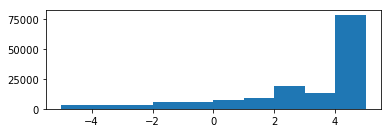

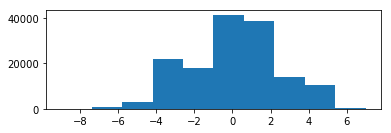

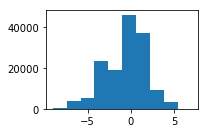

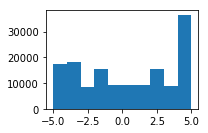

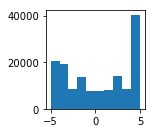

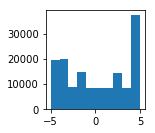

In [36]:
import matplotlib.pyplot as plt

plt.subplot(211)
#plt.plot(bin1,'.')
plt.hist(bin1)
plt.show()
plt.subplot(212)
#plt.plot(bin2,'.')
plt.hist(bin2)
plt.show()
plt.subplot(221)
#plt.plot(bin3,'.')
plt.hist(bin3)
plt.show()
plt.subplot(222)
plt.hist(bin11)
plt.show()
plt.subplot(231)
plt.hist(bin12)
plt.show()
plt.subplot(232)
plt.hist(bin13)
plt.show()

In [19]:
import operator
sorted_q = sorted(Q.items(),key=operator.itemgetter(1))
#print(sorted_q[-100:])
print(sorted_q[-5:])

[((1, (0.0, -5.0, -0.0, -5.0, -2.0, 0.0)), -0.11075862013897061), ((0, (-1.0, 5.0, -3.0, 4.0, 1.0, -2.0)), -0.10990592766788575), ((0, (1.0, -5.0, 0.0, -5.0, -3.0, 1.0)), -0.10402178767654051), ((0, (1.0, 5.0, -3.0, 4.0, 2.0, -2.0)), -0.056801349901115926), ((1, (-0.0, 5.0, -3.0, 4.0, 2.0, -2.0)), -0.014286214718484166)]


In [33]:
state = env.reset()
#env.render()
for i in range(10):
    state = env.reset()
    env.render()
    for j in range(500):
        _,action = get_max_state_action(Q,action_space,state,round_place)
        state,reward,done,_ = env.step(action)
        if done:
            print('episode done after {}'.format(j))
            break
        
env.render(close=True)

episode done after 499
episode done after 343
episode done after 499
episode done after 499
episode done after 389
episode done after 499
episode done after 499
episode done after 499
episode done after 499
episode done after 499


In [ ]:
#how to update q values in a chain
#store every reward and action space along the chain
    #need to make sure they are paired up. ie this action led to this reward at the next step
#at the end of the chain, iter through each reward and action
    #I believe most efficient way is to start backwards then for each iter, multiply the future reward by the discount

In [ ]:
#sarsa lambda from Silver RL course
#initialize Q(s,a) DONE
#need a eligibility table, initialized at 0 (can do this by just get for 0)
#when that state,action combo is found, turn E(S,A) += 1
#grab the next Q(S',A') (me: this is supposed to be done from the on policy so I guess have to know best/random prior to this)
#calculate delta
#then go through all S and A (can simplify by just doing the ones you have found)
    #update the Q values
    #decay the E values
#me: if it's every step it's sarsa, if it's at the end of the episode I think it's MC

#me: by binning the states so severely, I wonder if it will have an issue trying to break out of the early states 
    #(ie won't know how to wiggle early, all states will look equally poor

In [43]:
def bin_states(state,angle_bins):
    
    for i in range(6):
        if i < 4:
            state[i] = np.round(state[i] * angle_bins,0) 
        elif i == 4:
            temp_int = np.round(state[i],0)
            if temp_int < -9:
                temp_int = -9
            elif temp_int > 9:
                temp_int = 9
            state[i] = temp_int
        elif i == 5:
            temp_int = np.round(state[i],0)
            if temp_int < -9:
                temp_int = -9
            elif temp_int > 9:
                temp_int = 9
            state[i] = temp_int
    return state        

In [44]:
#so trying end of episode based updating. I believe it's MC (I think TD(lambda) would have a lambda value)

#hyperparameters
episodes = 1000000
report_steps = 100
e_max = 1.
e_min = 0.05
e_decay = (e_max - e_min)/episodes #just doing it linearly 
max_steps = 500
alpha = 0.3
alpha_decay = 0.8
alpha_decay_mod = episodes/10
round_place = 10
gamma = 0.95


In [45]:
action_space = [0,1,2]
Q = {}
episode_states = []
episode_rewards = []
steps = 0
#step_array = []
recent_step_array = []

for i in range(episodes):#range(10):#
    state = env.reset()
    state = bin_states(state,10)
    steps += 1
    episode_states = []
    episode_rewards = []
    episode_actions = []
    
    for j in range(max_steps):
        episode_states.append(state)
        explore_prob = e_max - e_decay*steps
        if np.random.rand() <= explore_prob:
            #choose randomly
            action = env.action_space.sample()
        else:
            _,action = get_max_state_action(Q,action_space,state,round_place)
            
        next_state,reward,done,_ = env.step(action)
        next_state = bin_states(next_state,10)
        episode_actions.append(action)
        episode_rewards.append(reward)
        
        if done:
            #iterate backwards, starting with future reward of 0
                #algorithms I have seen start and discount future rewards but I think this saves
                #calculations and works because all rewards except for the terminal one are -1
            if j >= 499:
                g_reward = -1
            else:
                g_reward = 0
                
            for k in range(j,-1,-1):
                g_reward = gamma*g_reward
                g_reward = episode_rewards[k] + g_reward
                q_value = get_q_value(Q,episode_actions[k],episode_states[k],round_place)
                q_update = q_value + alpha*(g_reward-q_value)
                add_to_q(Q,episode_actions[k],episode_states[k],q_update,round_place)
  
            recent_step_array.append(j)
            if i % report_steps == 0:
                print("episode {}".format(i), " steps: {}".format(j), 
                      " avg. steps {}".format(np.mean(recent_step_array)), " e: {} ".format(explore_prob))
                recent_step_array = []
            break
        else:
            state = next_state
    #decay alpha rate
    if i % alpha_decay_mod == 0:
        #print('decaying alpha {}'.format(episodes))
        alpha = alpha * alpha_decay

episode 0  steps: 499  avg. steps 499.0  e: 0.99999905 
episode 100  steps: 499  avg. steps 496.58  e: 0.99990405 
episode 200  steps: 499  avg. steps 499.0  e: 0.99980905 
episode 300  steps: 499  avg. steps 498.48  e: 0.99971405 
episode 400  steps: 499  avg. steps 496.9  e: 0.99961905 
episode 500  steps: 499  avg. steps 496.29  e: 0.99952405 
episode 600  steps: 499  avg. steps 497.39  e: 0.99942905 
episode 700  steps: 499  avg. steps 498.44  e: 0.99933405 
episode 800  steps: 499  avg. steps 495.59  e: 0.99923905 
episode 900  steps: 499  avg. steps 499.0  e: 0.99914405 
episode 1000  steps: 499  avg. steps 498.9  e: 0.99904905 
episode 1100  steps: 499  avg. steps 498.49  e: 0.99895405 
episode 1200  steps: 499  avg. steps 497.88  e: 0.99885905 
episode 1300  steps: 499  avg. steps 498.44  e: 0.99876405 
episode 1400  steps: 499  avg. steps 498.29  e: 0.99866905 
episode 1500  steps: 499  avg. steps 497.58  e: 0.99857405 
episode 1600  steps: 499  avg. steps 498.16  e: 0.9984790

episode 13700  steps: 499  avg. steps 496.71  e: 0.98698405 
episode 13800  steps: 499  avg. steps 498.23  e: 0.98688905 
episode 13900  steps: 499  avg. steps 497.8  e: 0.98679405 
episode 14000  steps: 499  avg. steps 498.29  e: 0.98669905 
episode 14100  steps: 499  avg. steps 497.17  e: 0.98660405 
episode 14200  steps: 499  avg. steps 498.3  e: 0.98650905 
episode 14300  steps: 499  avg. steps 495.74  e: 0.98641405 
episode 14400  steps: 499  avg. steps 496.94  e: 0.98631905 
episode 14500  steps: 499  avg. steps 496.73  e: 0.98622405 
episode 14600  steps: 499  avg. steps 499.0  e: 0.98612905 
episode 14700  steps: 499  avg. steps 498.89  e: 0.98603405 
episode 14800  steps: 499  avg. steps 499.0  e: 0.98593905 
episode 14900  steps: 499  avg. steps 499.0  e: 0.98584405 
episode 15000  steps: 499  avg. steps 499.0  e: 0.98574905 
episode 15100  steps: 499  avg. steps 498.45  e: 0.98565405 
episode 15200  steps: 499  avg. steps 497.37  e: 0.98555905 
episode 15300  steps: 499  avg

episode 27200  steps: 499  avg. steps 497.07  e: 0.97415905 
episode 27300  steps: 499  avg. steps 498.81  e: 0.97406405 
episode 27400  steps: 499  avg. steps 498.68  e: 0.97396905 
episode 27500  steps: 499  avg. steps 498.44  e: 0.97387405 
episode 27600  steps: 499  avg. steps 498.74  e: 0.97377905 
episode 27700  steps: 499  avg. steps 498.35  e: 0.97368405 
episode 27800  steps: 499  avg. steps 497.99  e: 0.97358905 
episode 27900  steps: 499  avg. steps 496.21  e: 0.97349405 
episode 28000  steps: 499  avg. steps 499.0  e: 0.97339905 
episode 28100  steps: 499  avg. steps 497.77  e: 0.97330405 
episode 28200  steps: 499  avg. steps 498.25  e: 0.97320905 
episode 28300  steps: 499  avg. steps 498.15  e: 0.97311405 
episode 28400  steps: 499  avg. steps 497.66  e: 0.97301905 
episode 28500  steps: 499  avg. steps 499.0  e: 0.97292405 
episode 28600  steps: 499  avg. steps 498.36  e: 0.97282905 
episode 28700  steps: 499  avg. steps 497.56  e: 0.97273405 
episode 28800  steps: 499 

episode 40700  steps: 499  avg. steps 498.85  e: 0.96133405 
episode 40800  steps: 499  avg. steps 497.38  e: 0.96123905 
episode 40900  steps: 499  avg. steps 498.6  e: 0.96114405 
episode 41000  steps: 499  avg. steps 498.66  e: 0.96104905 
episode 41100  steps: 499  avg. steps 498.92  e: 0.96095405 
episode 41200  steps: 499  avg. steps 498.56  e: 0.96085905 
episode 41300  steps: 499  avg. steps 497.42  e: 0.96076405 
episode 41400  steps: 499  avg. steps 498.84  e: 0.96066905 
episode 41500  steps: 499  avg. steps 499.0  e: 0.96057405 
episode 41600  steps: 499  avg. steps 496.5  e: 0.96047905 
episode 41700  steps: 499  avg. steps 497.66  e: 0.96038405 
episode 41800  steps: 499  avg. steps 499.0  e: 0.96028905 
episode 41900  steps: 499  avg. steps 496.48  e: 0.96019405 
episode 42000  steps: 499  avg. steps 499.0  e: 0.96009905 
episode 42100  steps: 499  avg. steps 495.35  e: 0.96000405 
episode 42200  steps: 499  avg. steps 499.0  e: 0.95990905 
episode 42300  steps: 499  avg

episode 54100  steps: 499  avg. steps 497.45  e: 0.94860405 
episode 54200  steps: 499  avg. steps 498.75  e: 0.94850905 
episode 54300  steps: 499  avg. steps 497.22  e: 0.94841405 
episode 54400  steps: 499  avg. steps 498.28  e: 0.94831905 
episode 54500  steps: 499  avg. steps 499.0  e: 0.94822405 
episode 54600  steps: 499  avg. steps 498.19  e: 0.94812905 
episode 54700  steps: 499  avg. steps 498.34  e: 0.94803405 
episode 54800  steps: 499  avg. steps 498.97  e: 0.94793905 
episode 54900  steps: 499  avg. steps 498.0  e: 0.94784405 
episode 55000  steps: 499  avg. steps 499.0  e: 0.94774905 
episode 55100  steps: 499  avg. steps 498.97  e: 0.94765405 
episode 55200  steps: 499  avg. steps 496.28  e: 0.94755905 
episode 55300  steps: 499  avg. steps 498.28  e: 0.94746405 
episode 55400  steps: 499  avg. steps 498.22  e: 0.94736905 
episode 55500  steps: 499  avg. steps 499.0  e: 0.94727405 
episode 55600  steps: 499  avg. steps 495.71  e: 0.94717905 
episode 55700  steps: 499  a

episode 67500  steps: 499  avg. steps 496.09  e: 0.93587405 
episode 67600  steps: 499  avg. steps 494.4  e: 0.9357790500000001 
episode 67700  steps: 499  avg. steps 497.05  e: 0.93568405 
episode 67800  steps: 499  avg. steps 498.81  e: 0.93558905 
episode 67900  steps: 499  avg. steps 498.41  e: 0.93549405 
episode 68000  steps: 499  avg. steps 494.42  e: 0.93539905 
episode 68100  steps: 499  avg. steps 497.74  e: 0.93530405 
episode 68200  steps: 499  avg. steps 498.35  e: 0.93520905 
episode 68300  steps: 499  avg. steps 497.7  e: 0.93511405 
episode 68400  steps: 499  avg. steps 497.94  e: 0.93501905 
episode 68500  steps: 499  avg. steps 498.28  e: 0.93492405 
episode 68600  steps: 499  avg. steps 499.0  e: 0.93482905 
episode 68700  steps: 499  avg. steps 498.16  e: 0.93473405 
episode 68800  steps: 499  avg. steps 497.04  e: 0.93463905 
episode 68900  steps: 499  avg. steps 497.81  e: 0.93454405 
episode 69000  steps: 499  avg. steps 498.02  e: 0.93444905 
episode 69100  step

episode 80900  steps: 499  avg. steps 498.3  e: 0.92314405 
episode 81000  steps: 499  avg. steps 498.47  e: 0.92304905 
episode 81100  steps: 499  avg. steps 497.43  e: 0.92295405 
episode 81200  steps: 499  avg. steps 499.0  e: 0.92285905 
episode 81300  steps: 499  avg. steps 497.46  e: 0.9227640500000001 
episode 81400  steps: 499  avg. steps 498.46  e: 0.92266905 
episode 81500  steps: 314  avg. steps 494.73  e: 0.92257405 
episode 81600  steps: 499  avg. steps 498.25  e: 0.92247905 
episode 81700  steps: 499  avg. steps 497.89  e: 0.92238405 
episode 81800  steps: 499  avg. steps 497.07  e: 0.92228905 
episode 81900  steps: 499  avg. steps 499.0  e: 0.92219405 
episode 82000  steps: 499  avg. steps 497.26  e: 0.92209905 
episode 82100  steps: 499  avg. steps 495.41  e: 0.92200405 
episode 82200  steps: 499  avg. steps 496.79  e: 0.92190905 
episode 82300  steps: 499  avg. steps 496.85  e: 0.92181405 
episode 82400  steps: 499  avg. steps 496.33  e: 0.92171905 
episode 82500  step

episode 94300  steps: 499  avg. steps 499.0  e: 0.91041405 
episode 94400  steps: 499  avg. steps 498.42  e: 0.91031905 
episode 94500  steps: 499  avg. steps 499.0  e: 0.9102240500000001 
episode 94600  steps: 499  avg. steps 495.22  e: 0.91012905 
episode 94700  steps: 499  avg. steps 494.38  e: 0.91003405 
episode 94800  steps: 499  avg. steps 496.76  e: 0.90993905 
episode 94900  steps: 499  avg. steps 498.26  e: 0.90984405 
episode 95000  steps: 499  avg. steps 497.19  e: 0.9097490500000001 
episode 95100  steps: 499  avg. steps 495.42  e: 0.90965405 
episode 95200  steps: 499  avg. steps 499.0  e: 0.90955905 
episode 95300  steps: 499  avg. steps 498.55  e: 0.90946405 
episode 95400  steps: 499  avg. steps 497.61  e: 0.90936905 
episode 95500  steps: 499  avg. steps 498.62  e: 0.9092740500000001 
episode 95600  steps: 499  avg. steps 497.85  e: 0.90917905 
episode 95700  steps: 499  avg. steps 498.5  e: 0.90908405 
episode 95800  steps: 499  avg. steps 497.7  e: 0.90898905 
episo

episode 107500  steps: 499  avg. steps 498.26  e: 0.89787405 
episode 107600  steps: 488  avg. steps 498.05  e: 0.89777905 
episode 107700  steps: 499  avg. steps 498.68  e: 0.8976840500000001 
episode 107800  steps: 499  avg. steps 494.87  e: 0.89758905 
episode 107900  steps: 499  avg. steps 499.0  e: 0.89749405 
episode 108000  steps: 499  avg. steps 496.57  e: 0.89739905 
episode 108100  steps: 499  avg. steps 499.0  e: 0.89730405 
episode 108200  steps: 499  avg. steps 496.95  e: 0.8972090500000001 
episode 108300  steps: 499  avg. steps 495.96  e: 0.89711405 
episode 108400  steps: 499  avg. steps 496.1  e: 0.89701905 
episode 108500  steps: 499  avg. steps 496.62  e: 0.89692405 
episode 108600  steps: 499  avg. steps 498.51  e: 0.89682905 
episode 108700  steps: 499  avg. steps 497.76  e: 0.8967340500000001 
episode 108800  steps: 499  avg. steps 499.0  e: 0.89663905 
episode 108900  steps: 499  avg. steps 497.2  e: 0.89654405 
episode 109000  steps: 499  avg. steps 498.16  e: 0

episode 120600  steps: 499  avg. steps 495.08  e: 0.88542905 
episode 120700  steps: 499  avg. steps 497.82  e: 0.88533405 
episode 120800  steps: 499  avg. steps 498.47  e: 0.88523905 
episode 120900  steps: 499  avg. steps 498.67  e: 0.8851440500000001 
episode 121000  steps: 499  avg. steps 497.85  e: 0.88504905 
episode 121100  steps: 499  avg. steps 492.9  e: 0.88495405 
episode 121200  steps: 499  avg. steps 498.53  e: 0.88485905 
episode 121300  steps: 499  avg. steps 497.7  e: 0.88476405 
episode 121400  steps: 499  avg. steps 497.93  e: 0.8846690500000001 
episode 121500  steps: 499  avg. steps 496.88  e: 0.88457405 
episode 121600  steps: 499  avg. steps 495.82  e: 0.88447905 
episode 121700  steps: 499  avg. steps 498.24  e: 0.88438405 
episode 121800  steps: 499  avg. steps 498.01  e: 0.88428905 
episode 121900  steps: 376  avg. steps 493.78  e: 0.8841940500000001 
episode 122000  steps: 499  avg. steps 499.0  e: 0.88409905 
episode 122100  steps: 499  avg. steps 498.68  e:

episode 133700  steps: 499  avg. steps 497.78  e: 0.87298405 
episode 133800  steps: 499  avg. steps 498.73  e: 0.8728890499999999 
episode 133900  steps: 499  avg. steps 496.13  e: 0.87279405 
episode 134000  steps: 499  avg. steps 496.24  e: 0.87269905 
episode 134100  steps: 499  avg. steps 498.31  e: 0.8726040500000001 
episode 134200  steps: 499  avg. steps 495.19  e: 0.87250905 
episode 134300  steps: 499  avg. steps 497.53  e: 0.87241405 
episode 134400  steps: 499  avg. steps 496.36  e: 0.87231905 
episode 134500  steps: 499  avg. steps 498.75  e: 0.87222405 
episode 134600  steps: 499  avg. steps 496.06  e: 0.8721290500000001 
episode 134700  steps: 499  avg. steps 497.33  e: 0.87203405 
episode 134800  steps: 499  avg. steps 495.39  e: 0.87193905 
episode 134900  steps: 499  avg. steps 496.51  e: 0.87184405 
episode 135000  steps: 499  avg. steps 497.34  e: 0.87174905 
episode 135100  steps: 499  avg. steps 495.9  e: 0.8716540500000001 
episode 135200  steps: 499  avg. steps 

episode 146700  steps: 499  avg. steps 494.63  e: 0.86063405 
episode 146800  steps: 499  avg. steps 495.11  e: 0.8605390500000001 
episode 146900  steps: 499  avg. steps 498.51  e: 0.86044405 
episode 147000  steps: 499  avg. steps 498.21  e: 0.86034905 
episode 147100  steps: 499  avg. steps 498.71  e: 0.86025405 
episode 147200  steps: 499  avg. steps 493.98  e: 0.86015905 
episode 147300  steps: 499  avg. steps 498.05  e: 0.8600640500000001 
episode 147400  steps: 499  avg. steps 497.19  e: 0.85996905 
episode 147500  steps: 499  avg. steps 496.82  e: 0.85987405 
episode 147600  steps: 499  avg. steps 495.84  e: 0.85977905 
episode 147700  steps: 499  avg. steps 494.56  e: 0.85968405 
episode 147800  steps: 499  avg. steps 495.66  e: 0.8595890500000001 
episode 147900  steps: 499  avg. steps 496.47  e: 0.85949405 
episode 148000  steps: 499  avg. steps 494.98  e: 0.85939905 
episode 148100  steps: 499  avg. steps 498.14  e: 0.85930405 
episode 148200  steps: 499  avg. steps 497.07 

episode 159700  steps: 499  avg. steps 496.32  e: 0.84828405 
episode 159800  steps: 499  avg. steps 496.74  e: 0.84818905 
episode 159900  steps: 499  avg. steps 494.55  e: 0.84809405 
episode 160000  steps: 499  avg. steps 496.97  e: 0.84799905 
episode 160100  steps: 499  avg. steps 495.91  e: 0.84790405 
episode 160200  steps: 499  avg. steps 494.96  e: 0.84780905 
episode 160300  steps: 499  avg. steps 494.61  e: 0.84771405 
episode 160400  steps: 499  avg. steps 495.77  e: 0.84761905 
episode 160500  steps: 499  avg. steps 498.07  e: 0.8475240500000001 
episode 160600  steps: 499  avg. steps 494.27  e: 0.84742905 
episode 160700  steps: 499  avg. steps 497.99  e: 0.84733405 
episode 160800  steps: 499  avg. steps 495.94  e: 0.84723905 
episode 160900  steps: 499  avg. steps 497.68  e: 0.84714405 
episode 161000  steps: 499  avg. steps 495.01  e: 0.8470490500000001 
episode 161100  steps: 499  avg. steps 498.45  e: 0.84695405 
episode 161200  steps: 499  avg. steps 495.12  e: 0.84

episode 172700  steps: 499  avg. steps 498.5  e: 0.83593405 
episode 172800  steps: 499  avg. steps 496.5  e: 0.83583905 
episode 172900  steps: 499  avg. steps 494.48  e: 0.83574405 
episode 173000  steps: 499  avg. steps 497.3  e: 0.83564905 
episode 173100  steps: 499  avg. steps 498.65  e: 0.83555405 
episode 173200  steps: 499  avg. steps 498.94  e: 0.83545905 
episode 173300  steps: 499  avg. steps 497.11  e: 0.83536405 
episode 173400  steps: 499  avg. steps 498.24  e: 0.83526905 
episode 173500  steps: 499  avg. steps 492.22  e: 0.83517405 
episode 173600  steps: 499  avg. steps 496.47  e: 0.83507905 
episode 173700  steps: 499  avg. steps 498.1  e: 0.83498405 
episode 173800  steps: 499  avg. steps 498.6  e: 0.83488905 
episode 173900  steps: 499  avg. steps 497.75  e: 0.83479405 
episode 174000  steps: 499  avg. steps 497.6  e: 0.83469905 
episode 174100  steps: 499  avg. steps 493.19  e: 0.83460405 
episode 174200  steps: 499  avg. steps 493.48  e: 0.8345090500000001 
episod

episode 185700  steps: 380  avg. steps 494.55  e: 0.82358405 
episode 185800  steps: 499  avg. steps 495.33  e: 0.8234890500000001 
episode 185900  steps: 499  avg. steps 497.4  e: 0.82339405 
episode 186000  steps: 499  avg. steps 497.56  e: 0.82329905 
episode 186100  steps: 499  avg. steps 496.65  e: 0.82320405 
episode 186200  steps: 499  avg. steps 498.41  e: 0.82310905 
episode 186300  steps: 499  avg. steps 497.24  e: 0.82301405 
episode 186400  steps: 499  avg. steps 496.2  e: 0.82291905 
episode 186500  steps: 499  avg. steps 497.54  e: 0.82282405 
episode 186600  steps: 499  avg. steps 497.03  e: 0.82272905 
episode 186700  steps: 499  avg. steps 494.75  e: 0.82263405 
episode 186800  steps: 499  avg. steps 496.29  e: 0.82253905 
episode 186900  steps: 499  avg. steps 493.66  e: 0.82244405 
episode 187000  steps: 499  avg. steps 496.42  e: 0.82234905 
episode 187100  steps: 499  avg. steps 496.76  e: 0.82225405 
episode 187200  steps: 499  avg. steps 490.95  e: 0.82215905 
ep

episode 198700  steps: 499  avg. steps 493.49  e: 0.81123405 
episode 198800  steps: 499  avg. steps 497.85  e: 0.81113905 
episode 198900  steps: 499  avg. steps 495.97  e: 0.81104405 
episode 199000  steps: 499  avg. steps 494.66  e: 0.8109490500000001 
episode 199100  steps: 499  avg. steps 495.79  e: 0.81085405 
episode 199200  steps: 499  avg. steps 495.29  e: 0.81075905 
episode 199300  steps: 499  avg. steps 494.1  e: 0.81066405 
episode 199400  steps: 499  avg. steps 496.91  e: 0.81056905 
episode 199500  steps: 499  avg. steps 495.59  e: 0.8104740500000001 
episode 199600  steps: 499  avg. steps 494.2  e: 0.81037905 
episode 199700  steps: 499  avg. steps 492.78  e: 0.81028405 
episode 199800  steps: 499  avg. steps 497.89  e: 0.81018905 
episode 199900  steps: 499  avg. steps 496.43  e: 0.81009405 
episode 200000  steps: 499  avg. steps 493.14  e: 0.80999905 
episode 200100  steps: 499  avg. steps 491.94  e: 0.80990405 
episode 200200  steps: 499  avg. steps 494.07  e: 0.8098

episode 211700  steps: 499  avg. steps 495.65  e: 0.7988840500000001 
episode 211800  steps: 499  avg. steps 497.24  e: 0.79878905 
episode 211900  steps: 499  avg. steps 497.77  e: 0.79869405 
episode 212000  steps: 499  avg. steps 495.49  e: 0.79859905 
episode 212100  steps: 499  avg. steps 496.29  e: 0.79850405 
episode 212200  steps: 499  avg. steps 495.43  e: 0.7984090500000001 
episode 212300  steps: 499  avg. steps 494.62  e: 0.79831405 
episode 212400  steps: 499  avg. steps 494.32  e: 0.79821905 
episode 212500  steps: 499  avg. steps 495.08  e: 0.79812405 
episode 212600  steps: 303  avg. steps 492.85  e: 0.79802905 
episode 212700  steps: 499  avg. steps 494.24  e: 0.7979340500000001 
episode 212800  steps: 499  avg. steps 497.66  e: 0.79783905 
episode 212900  steps: 499  avg. steps 496.55  e: 0.79774405 
episode 213000  steps: 499  avg. steps 496.49  e: 0.79764905 
episode 213100  steps: 499  avg. steps 497.87  e: 0.79755405 
episode 213200  steps: 499  avg. steps 493.87 

episode 224600  steps: 499  avg. steps 495.09  e: 0.78662905 
episode 224700  steps: 499  avg. steps 497.1  e: 0.78653405 
episode 224800  steps: 499  avg. steps 497.77  e: 0.78643905 
episode 224900  steps: 499  avg. steps 494.11  e: 0.7863440500000001 
episode 225000  steps: 499  avg. steps 493.59  e: 0.78624905 
episode 225100  steps: 499  avg. steps 495.47  e: 0.78615405 
episode 225200  steps: 499  avg. steps 494.66  e: 0.78605905 
episode 225300  steps: 499  avg. steps 492.94  e: 0.78596405 
episode 225400  steps: 499  avg. steps 496.93  e: 0.7858690500000001 
episode 225500  steps: 499  avg. steps 493.62  e: 0.78577405 
episode 225600  steps: 499  avg. steps 498.21  e: 0.78567905 
episode 225700  steps: 499  avg. steps 493.91  e: 0.78558405 
episode 225800  steps: 499  avg. steps 493.74  e: 0.78548905 
episode 225900  steps: 499  avg. steps 496.75  e: 0.7853940500000001 
episode 226000  steps: 499  avg. steps 496.65  e: 0.78529905 
episode 226100  steps: 499  avg. steps 497.59  

episode 237500  steps: 499  avg. steps 495.37  e: 0.77437405 
episode 237600  steps: 499  avg. steps 496.78  e: 0.7742790500000001 
episode 237700  steps: 499  avg. steps 494.97  e: 0.77418405 
episode 237800  steps: 499  avg. steps 498.01  e: 0.7740890500000001 
episode 237900  steps: 499  avg. steps 489.1  e: 0.77399405 
episode 238000  steps: 499  avg. steps 496.09  e: 0.77389905 
episode 238100  steps: 499  avg. steps 494.42  e: 0.7738040500000001 
episode 238200  steps: 499  avg. steps 494.62  e: 0.77370905 
episode 238300  steps: 499  avg. steps 495.62  e: 0.77361405 
episode 238400  steps: 499  avg. steps 495.14  e: 0.77351905 
episode 238500  steps: 499  avg. steps 487.58  e: 0.77342405 
episode 238600  steps: 499  avg. steps 498.79  e: 0.7733290500000001 
episode 238700  steps: 499  avg. steps 496.75  e: 0.77323405 
episode 238800  steps: 499  avg. steps 496.57  e: 0.77313905 
episode 238900  steps: 499  avg. steps 494.61  e: 0.77304405 
episode 239000  steps: 499  avg. steps 

episode 250500  steps: 499  avg. steps 495.66  e: 0.7620240500000001 
episode 250600  steps: 499  avg. steps 493.67  e: 0.76192905 
episode 250700  steps: 499  avg. steps 493.9  e: 0.76183405 
episode 250800  steps: 499  avg. steps 494.67  e: 0.7617390500000001 
episode 250900  steps: 499  avg. steps 497.24  e: 0.76164405 
episode 251000  steps: 499  avg. steps 496.27  e: 0.7615490500000001 
episode 251100  steps: 499  avg. steps 494.06  e: 0.76145405 
episode 251200  steps: 499  avg. steps 496.27  e: 0.76135905 
episode 251300  steps: 499  avg. steps 494.88  e: 0.7612640500000001 
episode 251400  steps: 499  avg. steps 493.23  e: 0.76116905 
episode 251500  steps: 499  avg. steps 495.08  e: 0.7610740500000001 
episode 251600  steps: 499  avg. steps 497.13  e: 0.76097905 
episode 251700  steps: 499  avg. steps 496.68  e: 0.76088405 
episode 251800  steps: 499  avg. steps 493.69  e: 0.7607890500000001 
episode 251900  steps: 499  avg. steps 492.48  e: 0.76069405 
episode 252000  steps: 

episode 263400  steps: 499  avg. steps 489.94  e: 0.74976905 
episode 263500  steps: 499  avg. steps 498.87  e: 0.7496740500000001 
episode 263600  steps: 499  avg. steps 495.14  e: 0.74957905 
episode 263700  steps: 499  avg. steps 495.81  e: 0.74948405 
episode 263800  steps: 499  avg. steps 492.84  e: 0.74938905 
episode 263900  steps: 449  avg. steps 491.97  e: 0.74929405 
episode 264000  steps: 499  avg. steps 495.78  e: 0.7491990500000001 
episode 264100  steps: 499  avg. steps 496.93  e: 0.74910405 
episode 264200  steps: 499  avg. steps 494.78  e: 0.74900905 
episode 264300  steps: 499  avg. steps 492.26  e: 0.74891405 
episode 264400  steps: 499  avg. steps 492.55  e: 0.74881905 
episode 264500  steps: 499  avg. steps 495.29  e: 0.7487240500000001 
episode 264600  steps: 499  avg. steps 492.66  e: 0.74862905 
episode 264700  steps: 420  avg. steps 492.15  e: 0.74853405 
episode 264800  steps: 499  avg. steps 497.33  e: 0.74843905 
episode 264900  steps: 499  avg. steps 493.76 

episode 276200  steps: 499  avg. steps 493.9  e: 0.7376090500000001 
episode 276300  steps: 499  avg. steps 491.92  e: 0.73751405 
episode 276400  steps: 499  avg. steps 497.54  e: 0.73741905 
episode 276500  steps: 499  avg. steps 494.55  e: 0.73732405 
episode 276600  steps: 499  avg. steps 495.1  e: 0.73722905 
episode 276700  steps: 499  avg. steps 497.16  e: 0.7371340500000001 
episode 276800  steps: 499  avg. steps 497.06  e: 0.73703905 
episode 276900  steps: 499  avg. steps 491.82  e: 0.73694405 
episode 277000  steps: 499  avg. steps 488.69  e: 0.73684905 
episode 277100  steps: 499  avg. steps 494.17  e: 0.73675405 
episode 277200  steps: 499  avg. steps 495.24  e: 0.7366590500000001 
episode 277300  steps: 499  avg. steps 498.39  e: 0.73656405 
episode 277400  steps: 499  avg. steps 492.59  e: 0.73646905 
episode 277500  steps: 499  avg. steps 495.42  e: 0.73637405 
episode 277600  steps: 499  avg. steps 493.96  e: 0.73627905 
episode 277700  steps: 499  avg. steps 495.04  e

episode 289000  steps: 499  avg. steps 494.47  e: 0.72544905 
episode 289100  steps: 499  avg. steps 490.48  e: 0.72535405 
episode 289200  steps: 499  avg. steps 495.02  e: 0.72525905 
episode 289300  steps: 499  avg. steps 492.44  e: 0.7251640500000001 
episode 289400  steps: 499  avg. steps 494.14  e: 0.7250690500000001 
episode 289500  steps: 499  avg. steps 492.17  e: 0.72497405 
episode 289600  steps: 499  avg. steps 494.04  e: 0.72487905 
episode 289700  steps: 499  avg. steps 497.67  e: 0.72478405 
episode 289800  steps: 410  avg. steps 490.28  e: 0.7246890500000001 
episode 289900  steps: 499  avg. steps 495.45  e: 0.7245940500000001 
episode 290000  steps: 499  avg. steps 492.63  e: 0.72449905 
episode 290100  steps: 499  avg. steps 492.77  e: 0.72440405 
episode 290200  steps: 499  avg. steps 491.32  e: 0.72430905 
episode 290300  steps: 499  avg. steps 492.96  e: 0.72421405 
episode 290400  steps: 499  avg. steps 492.97  e: 0.7241190500000001 
episode 290500  steps: 499  av

episode 301800  steps: 499  avg. steps 497.47  e: 0.71328905 
episode 301900  steps: 499  avg. steps 494.24  e: 0.71319405 
episode 302000  steps: 499  avg. steps 494.65  e: 0.7130990500000001 
episode 302100  steps: 499  avg. steps 492.86  e: 0.7130040500000001 
episode 302200  steps: 499  avg. steps 495.51  e: 0.71290905 
episode 302300  steps: 499  avg. steps 496.39  e: 0.71281405 
episode 302400  steps: 499  avg. steps 496.35  e: 0.71271905 
episode 302500  steps: 499  avg. steps 490.04  e: 0.7126240500000001 
episode 302600  steps: 499  avg. steps 495.77  e: 0.7125290500000001 
episode 302700  steps: 499  avg. steps 488.47  e: 0.71243405 
episode 302800  steps: 499  avg. steps 492.68  e: 0.71233905 
episode 302900  steps: 499  avg. steps 492.22  e: 0.71224405 
episode 303000  steps: 499  avg. steps 493.82  e: 0.7121490500000001 
episode 303100  steps: 499  avg. steps 496.03  e: 0.7120540500000001 
episode 303200  steps: 499  avg. steps 490.79  e: 0.71195905 
episode 303300  steps:

episode 314600  steps: 499  avg. steps 495.0  e: 0.70112905 
episode 314700  steps: 499  avg. steps 491.55  e: 0.7010340500000001 
episode 314800  steps: 499  avg. steps 496.85  e: 0.70093905 
episode 314900  steps: 499  avg. steps 492.23  e: 0.70084405 
episode 315000  steps: 499  avg. steps 492.83  e: 0.70074905 
episode 315100  steps: 499  avg. steps 497.18  e: 0.70065405 
episode 315200  steps: 499  avg. steps 494.34  e: 0.7005590500000001 
episode 315300  steps: 499  avg. steps 492.56  e: 0.70046405 
episode 315400  steps: 499  avg. steps 489.52  e: 0.70036905 
episode 315500  steps: 499  avg. steps 495.44  e: 0.70027405 
episode 315600  steps: 499  avg. steps 489.6  e: 0.70017905 
episode 315700  steps: 499  avg. steps 493.95  e: 0.7000840500000001 
episode 315800  steps: 499  avg. steps 490.84  e: 0.6999890500000001 
episode 315900  steps: 499  avg. steps 491.65  e: 0.69989405 
episode 316000  steps: 499  avg. steps 496.9  e: 0.69979905 
episode 316100  steps: 499  avg. steps 49

episode 327400  steps: 499  avg. steps 490.57  e: 0.6889690500000001 
episode 327500  steps: 499  avg. steps 495.25  e: 0.68887405 
episode 327600  steps: 499  avg. steps 494.83  e: 0.68877905 
episode 327700  steps: 499  avg. steps 492.48  e: 0.68868405 
episode 327800  steps: 499  avg. steps 495.7  e: 0.68858905 
episode 327900  steps: 499  avg. steps 497.1  e: 0.6884940500000001 
episode 328000  steps: 499  avg. steps 492.74  e: 0.68839905 
episode 328100  steps: 499  avg. steps 495.64  e: 0.6883040500000001 
episode 328200  steps: 499  avg. steps 492.16  e: 0.68820905 
episode 328300  steps: 499  avg. steps 495.24  e: 0.68811405 
episode 328400  steps: 499  avg. steps 492.06  e: 0.6880190500000001 
episode 328500  steps: 499  avg. steps 494.38  e: 0.68792405 
episode 328600  steps: 499  avg. steps 492.46  e: 0.68782905 
episode 328700  steps: 499  avg. steps 492.31  e: 0.68773405 
episode 328800  steps: 499  avg. steps 489.46  e: 0.68763905 
episode 328900  steps: 499  avg. steps 4

episode 340200  steps: 499  avg. steps 490.69  e: 0.67680905 
episode 340300  steps: 499  avg. steps 492.12  e: 0.67671405 
episode 340400  steps: 499  avg. steps 492.8  e: 0.67661905 
episode 340500  steps: 499  avg. steps 493.3  e: 0.67652405 
episode 340600  steps: 499  avg. steps 489.23  e: 0.6764290500000001 
episode 340700  steps: 499  avg. steps 491.88  e: 0.67633405 
episode 340800  steps: 499  avg. steps 494.7  e: 0.67623905 
episode 340900  steps: 499  avg. steps 490.68  e: 0.67614405 
episode 341000  steps: 499  avg. steps 495.87  e: 0.67604905 
episode 341100  steps: 499  avg. steps 493.03  e: 0.6759540500000001 
episode 341200  steps: 499  avg. steps 491.67  e: 0.67585905 
episode 341300  steps: 499  avg. steps 490.7  e: 0.67576405 
episode 341400  steps: 499  avg. steps 493.56  e: 0.67566905 
episode 341500  steps: 499  avg. steps 491.47  e: 0.67557405 
episode 341600  steps: 499  avg. steps 492.68  e: 0.6754790500000001 
episode 341700  steps: 416  avg. steps 491.89  e: 

episode 353000  steps: 499  avg. steps 495.25  e: 0.66464905 
episode 353100  steps: 499  avg. steps 488.54  e: 0.66455405 
episode 353200  steps: 499  avg. steps 493.25  e: 0.66445905 
episode 353300  steps: 499  avg. steps 489.04  e: 0.6643640500000001 
episode 353400  steps: 499  avg. steps 493.59  e: 0.66426905 
episode 353500  steps: 499  avg. steps 492.48  e: 0.66417405 
episode 353600  steps: 499  avg. steps 489.79  e: 0.66407905 
episode 353700  steps: 499  avg. steps 493.72  e: 0.66398405 
episode 353800  steps: 296  avg. steps 493.34  e: 0.6638890500000001 
episode 353900  steps: 499  avg. steps 495.25  e: 0.66379405 
episode 354000  steps: 499  avg. steps 495.09  e: 0.66369905 
episode 354100  steps: 499  avg. steps 488.01  e: 0.66360405 
episode 354200  steps: 461  avg. steps 488.73  e: 0.66350905 
episode 354300  steps: 499  avg. steps 493.84  e: 0.6634140500000001 
episode 354400  steps: 499  avg. steps 491.44  e: 0.66331905 
episode 354500  steps: 499  avg. steps 495.38 

episode 365700  steps: 499  avg. steps 494.04  e: 0.65258405 
episode 365800  steps: 499  avg. steps 488.78  e: 0.65248905 
episode 365900  steps: 499  avg. steps 494.07  e: 0.6523940500000001 
episode 366000  steps: 499  avg. steps 495.11  e: 0.6522990500000001 
episode 366100  steps: 499  avg. steps 492.6  e: 0.65220405 
episode 366200  steps: 499  avg. steps 489.63  e: 0.65210905 
episode 366300  steps: 499  avg. steps 491.62  e: 0.65201405 
episode 366400  steps: 499  avg. steps 494.98  e: 0.65191905 
episode 366500  steps: 499  avg. steps 493.79  e: 0.6518240500000001 
episode 366600  steps: 499  avg. steps 495.06  e: 0.65172905 
episode 366700  steps: 499  avg. steps 486.55  e: 0.65163405 
episode 366800  steps: 499  avg. steps 494.07  e: 0.65153905 
episode 366900  steps: 499  avg. steps 494.63  e: 0.65144405 
episode 367000  steps: 499  avg. steps 493.58  e: 0.6513490500000001 
episode 367100  steps: 499  avg. steps 492.28  e: 0.65125405 
episode 367200  steps: 499  avg. steps 

episode 378400  steps: 499  avg. steps 486.23  e: 0.64051905 
episode 378500  steps: 499  avg. steps 493.67  e: 0.64042405 
episode 378600  steps: 469  avg. steps 495.5  e: 0.6403290500000001 
episode 378700  steps: 499  avg. steps 491.52  e: 0.6402340500000001 
episode 378800  steps: 422  avg. steps 491.93  e: 0.64013905 
episode 378900  steps: 499  avg. steps 495.72  e: 0.64004405 
episode 379000  steps: 499  avg. steps 488.91  e: 0.63994905 
episode 379100  steps: 499  avg. steps 487.77  e: 0.6398540500000001 
episode 379200  steps: 499  avg. steps 493.93  e: 0.6397590500000001 
episode 379300  steps: 499  avg. steps 494.44  e: 0.63966405 
episode 379400  steps: 499  avg. steps 492.01  e: 0.63956905 
episode 379500  steps: 499  avg. steps 490.39  e: 0.63947405 
episode 379600  steps: 499  avg. steps 494.32  e: 0.6393790500000001 
episode 379700  steps: 499  avg. steps 492.31  e: 0.6392840500000001 
episode 379800  steps: 499  avg. steps 491.31  e: 0.63918905 
episode 379900  steps: 

episode 391100  steps: 499  avg. steps 497.21  e: 0.62845405 
episode 391200  steps: 499  avg. steps 491.06  e: 0.62835905 
episode 391300  steps: 499  avg. steps 494.98  e: 0.6282640500000001 
episode 391400  steps: 499  avg. steps 495.86  e: 0.6281690500000001 
episode 391500  steps: 499  avg. steps 492.92  e: 0.62807405 
episode 391600  steps: 499  avg. steps 493.35  e: 0.62797905 
episode 391700  steps: 499  avg. steps 486.13  e: 0.62788405 
episode 391800  steps: 499  avg. steps 498.11  e: 0.6277890500000001 
episode 391900  steps: 499  avg. steps 489.38  e: 0.6276940500000001 
episode 392000  steps: 499  avg. steps 493.87  e: 0.62759905 
episode 392100  steps: 499  avg. steps 493.39  e: 0.62750405 
episode 392200  steps: 499  avg. steps 491.19  e: 0.62740905 
episode 392300  steps: 499  avg. steps 494.69  e: 0.6273140500000001 
episode 392400  steps: 499  avg. steps 493.47  e: 0.6272190500000001 
episode 392500  steps: 499  avg. steps 491.71  e: 0.62712405 
episode 392600  steps:

episode 403800  steps: 499  avg. steps 494.0  e: 0.61638905 
episode 403900  steps: 499  avg. steps 496.16  e: 0.61629405 
episode 404000  steps: 499  avg. steps 490.12  e: 0.6161990500000001 
episode 404100  steps: 499  avg. steps 487.27  e: 0.61610405 
episode 404200  steps: 499  avg. steps 496.25  e: 0.6160090500000001 
episode 404300  steps: 499  avg. steps 496.62  e: 0.61591405 
episode 404400  steps: 499  avg. steps 488.53  e: 0.61581905 
episode 404500  steps: 499  avg. steps 493.04  e: 0.6157240500000001 
episode 404600  steps: 499  avg. steps 489.5  e: 0.6156290500000001 
episode 404700  steps: 499  avg. steps 492.08  e: 0.61553405 
episode 404800  steps: 499  avg. steps 493.54  e: 0.61543905 
episode 404900  steps: 458  avg. steps 482.99  e: 0.61534405 
episode 405000  steps: 499  avg. steps 484.6  e: 0.6152490500000001 
episode 405100  steps: 436  avg. steps 490.07  e: 0.6151540500000001 
episode 405200  steps: 499  avg. steps 487.6  e: 0.61505905 
episode 405300  steps: 499

episode 416500  steps: 440  avg. steps 488.52  e: 0.60432405 
episode 416600  steps: 499  avg. steps 492.02  e: 0.60422905 
episode 416700  steps: 499  avg. steps 491.84  e: 0.6041340500000001 
episode 416800  steps: 499  avg. steps 497.2  e: 0.60403905 
episode 416900  steps: 499  avg. steps 487.66  e: 0.6039440500000001 
episode 417000  steps: 411  avg. steps 490.76  e: 0.60384905 
episode 417100  steps: 499  avg. steps 494.73  e: 0.60375405 
episode 417200  steps: 499  avg. steps 494.93  e: 0.6036590500000001 
episode 417300  steps: 499  avg. steps 492.26  e: 0.60356405 
episode 417400  steps: 499  avg. steps 485.15  e: 0.6034690500000001 
episode 417500  steps: 499  avg. steps 491.23  e: 0.60337405 
episode 417600  steps: 499  avg. steps 490.88  e: 0.60327905 
episode 417700  steps: 499  avg. steps 491.68  e: 0.6031840500000001 
episode 417800  steps: 499  avg. steps 491.94  e: 0.60308905 
episode 417900  steps: 499  avg. steps 493.59  e: 0.6029940500000001 
episode 418000  steps: 

episode 429200  steps: 499  avg. steps 489.08  e: 0.59225905 
episode 429300  steps: 499  avg. steps 490.52  e: 0.59216405 
episode 429400  steps: 499  avg. steps 492.73  e: 0.5920690500000001 
episode 429500  steps: 499  avg. steps 495.48  e: 0.59197405 
episode 429600  steps: 499  avg. steps 493.7  e: 0.59187905 
episode 429700  steps: 499  avg. steps 488.62  e: 0.59178405 
episode 429800  steps: 499  avg. steps 484.31  e: 0.59168905 
episode 429900  steps: 499  avg. steps 488.48  e: 0.5915940500000001 
episode 430000  steps: 499  avg. steps 482.07  e: 0.59149905 
episode 430100  steps: 499  avg. steps 494.07  e: 0.59140405 
episode 430200  steps: 497  avg. steps 492.38  e: 0.59130905 
episode 430300  steps: 499  avg. steps 486.58  e: 0.59121405 
episode 430400  steps: 343  avg. steps 493.1  e: 0.5911190500000001 
episode 430500  steps: 484  avg. steps 488.22  e: 0.59102405 
episode 430600  steps: 499  avg. steps 495.05  e: 0.5909290500000001 
episode 430700  steps: 499  avg. steps 4

episode 441800  steps: 465  avg. steps 491.14  e: 0.58028905 
episode 441900  steps: 499  avg. steps 492.89  e: 0.58019405 
episode 442000  steps: 499  avg. steps 491.39  e: 0.5800990500000001 
episode 442100  steps: 499  avg. steps 495.54  e: 0.5800040500000001 
episode 442200  steps: 499  avg. steps 495.26  e: 0.57990905 
episode 442300  steps: 475  avg. steps 490.65  e: 0.57981405 
episode 442400  steps: 499  avg. steps 490.89  e: 0.57971905 
episode 442500  steps: 364  avg. steps 493.34  e: 0.5796240500000001 
episode 442600  steps: 499  avg. steps 493.93  e: 0.5795290500000001 
episode 442700  steps: 499  avg. steps 492.31  e: 0.57943405 
episode 442800  steps: 499  avg. steps 489.5  e: 0.57933905 
episode 442900  steps: 499  avg. steps 491.98  e: 0.57924405 
episode 443000  steps: 499  avg. steps 493.38  e: 0.57914905 
episode 443100  steps: 499  avg. steps 492.39  e: 0.5790540500000001 
episode 443200  steps: 480  avg. steps 489.81  e: 0.57895905 
episode 443300  steps: 499  avg

episode 454400  steps: 499  avg. steps 490.93  e: 0.56831905 
episode 454500  steps: 499  avg. steps 485.44  e: 0.56822405 
episode 454600  steps: 499  avg. steps 493.82  e: 0.56812905 
episode 454700  steps: 499  avg. steps 486.1  e: 0.5680340500000001 
episode 454800  steps: 499  avg. steps 489.43  e: 0.5679390500000001 
episode 454900  steps: 499  avg. steps 483.87  e: 0.56784405 
episode 455000  steps: 499  avg. steps 493.06  e: 0.56774905 
episode 455100  steps: 499  avg. steps 491.83  e: 0.56765405 
episode 455200  steps: 499  avg. steps 492.0  e: 0.5675590500000001 
episode 455300  steps: 499  avg. steps 496.36  e: 0.5674640500000001 
episode 455400  steps: 499  avg. steps 492.47  e: 0.56736905 
episode 455500  steps: 499  avg. steps 488.76  e: 0.56727405 
episode 455600  steps: 499  avg. steps 493.36  e: 0.56717905 
episode 455700  steps: 436  avg. steps 486.39  e: 0.5670840500000001 
episode 455800  steps: 499  avg. steps 495.4  e: 0.5669890500000001 
episode 455900  steps: 49

episode 467000  steps: 483  avg. steps 486.91  e: 0.5563490500000001 
episode 467100  steps: 499  avg. steps 497.12  e: 0.55625405 
episode 467200  steps: 499  avg. steps 490.23  e: 0.55615905 
episode 467300  steps: 499  avg. steps 485.88  e: 0.55606405 
episode 467400  steps: 499  avg. steps 492.37  e: 0.5559690500000001 
episode 467500  steps: 499  avg. steps 493.3  e: 0.5558740500000001 
episode 467600  steps: 499  avg. steps 489.85  e: 0.55577905 
episode 467700  steps: 499  avg. steps 491.64  e: 0.55568405 
episode 467800  steps: 499  avg. steps 490.14  e: 0.55558905 
episode 467900  steps: 499  avg. steps 493.02  e: 0.5554940500000001 
episode 468000  steps: 499  avg. steps 496.01  e: 0.5553990500000001 
episode 468100  steps: 445  avg. steps 489.03  e: 0.55530405 
episode 468200  steps: 499  avg. steps 491.06  e: 0.55520905 
episode 468300  steps: 499  avg. steps 493.25  e: 0.55511405 
episode 468400  steps: 499  avg. steps 492.28  e: 0.5550190500000001 
episode 468500  steps: 

episode 479600  steps: 499  avg. steps 491.26  e: 0.5443790500000001 
episode 479700  steps: 499  avg. steps 490.65  e: 0.54428405 
episode 479800  steps: 499  avg. steps 496.74  e: 0.5441890500000001 
episode 479900  steps: 499  avg. steps 485.81  e: 0.54409405 
episode 480000  steps: 499  avg. steps 493.77  e: 0.54399905 
episode 480100  steps: 499  avg. steps 496.41  e: 0.5439040500000001 
episode 480200  steps: 499  avg. steps 496.24  e: 0.5438090500000001 
episode 480300  steps: 499  avg. steps 489.37  e: 0.5437140500000001 
episode 480400  steps: 459  avg. steps 493.51  e: 0.54361905 
episode 480500  steps: 499  avg. steps 491.26  e: 0.54352405 
episode 480600  steps: 499  avg. steps 494.39  e: 0.5434290500000001 
episode 480700  steps: 499  avg. steps 487.35  e: 0.5433340500000001 
episode 480800  steps: 456  avg. steps 488.72  e: 0.5432390500000001 
episode 480900  steps: 499  avg. steps 490.74  e: 0.54314405 
episode 481000  steps: 499  avg. steps 484.06  e: 0.54304905 
episod

episode 492100  steps: 499  avg. steps 493.39  e: 0.53250405 
episode 492200  steps: 499  avg. steps 489.08  e: 0.53240905 
episode 492300  steps: 499  avg. steps 488.05  e: 0.5323140500000001 
episode 492400  steps: 499  avg. steps 490.48  e: 0.53221905 
episode 492500  steps: 499  avg. steps 495.85  e: 0.5321240500000001 
episode 492600  steps: 499  avg. steps 491.6  e: 0.53202905 
episode 492700  steps: 499  avg. steps 496.35  e: 0.53193405 
episode 492800  steps: 496  avg. steps 491.16  e: 0.5318390500000001 
episode 492900  steps: 499  avg. steps 490.18  e: 0.53174405 
episode 493000  steps: 499  avg. steps 494.51  e: 0.5316490500000001 
episode 493100  steps: 326  avg. steps 491.5  e: 0.53155405 
episode 493200  steps: 499  avg. steps 493.79  e: 0.53145905 
episode 493300  steps: 499  avg. steps 494.11  e: 0.5313640500000001 
episode 493400  steps: 499  avg. steps 485.86  e: 0.53126905 
episode 493500  steps: 499  avg. steps 497.47  e: 0.5311740500000001 
episode 493600  steps: 4

episode 504600  steps: 396  avg. steps 495.57  e: 0.52062905 
episode 504700  steps: 499  avg. steps 490.19  e: 0.52053405 
episode 504800  steps: 499  avg. steps 492.06  e: 0.52043905 
episode 504900  steps: 499  avg. steps 485.42  e: 0.5203440500000001 
episode 505000  steps: 499  avg. steps 486.61  e: 0.5202490500000001 
episode 505100  steps: 499  avg. steps 489.8  e: 0.52015405 
episode 505200  steps: 499  avg. steps 493.6  e: 0.52005905 
episode 505300  steps: 483  avg. steps 486.23  e: 0.51996405 
episode 505400  steps: 499  avg. steps 485.68  e: 0.51986905 
episode 505500  steps: 446  avg. steps 488.86  e: 0.5197740500000001 
episode 505600  steps: 499  avg. steps 492.3  e: 0.51967905 
episode 505700  steps: 499  avg. steps 495.72  e: 0.5195840500000001 
episode 505800  steps: 499  avg. steps 492.68  e: 0.51948905 
episode 505900  steps: 499  avg. steps 493.61  e: 0.51939405 
episode 506000  steps: 499  avg. steps 492.71  e: 0.5192990500000001 
episode 506100  steps: 499  avg. 

episode 517100  steps: 499  avg. steps 493.15  e: 0.5087540500000001 
episode 517200  steps: 499  avg. steps 488.59  e: 0.5086590500000001 
episode 517300  steps: 499  avg. steps 486.49  e: 0.50856405 
episode 517400  steps: 499  avg. steps 491.05  e: 0.50846905 
episode 517500  steps: 499  avg. steps 492.54  e: 0.50837405 
episode 517600  steps: 499  avg. steps 487.73  e: 0.5082790500000001 
episode 517700  steps: 499  avg. steps 492.54  e: 0.5081840500000001 
episode 517800  steps: 499  avg. steps 496.96  e: 0.50808905 
episode 517900  steps: 499  avg. steps 486.76  e: 0.50799405 
episode 518000  steps: 499  avg. steps 491.14  e: 0.50789905 
episode 518100  steps: 499  avg. steps 487.16  e: 0.5078040500000001 
episode 518200  steps: 499  avg. steps 489.5  e: 0.5077090500000001 
episode 518300  steps: 499  avg. steps 491.51  e: 0.50761405 
episode 518400  steps: 499  avg. steps 496.6  e: 0.50751905 
episode 518500  steps: 499  avg. steps 490.82  e: 0.50742405 
episode 518600  steps: 4

episode 529500  steps: 499  avg. steps 491.37  e: 0.49697405000000006 
episode 529600  steps: 499  avg. steps 490.92  e: 0.4968790500000001 
episode 529700  steps: 499  avg. steps 495.28  e: 0.49678405000000003 
episode 529800  steps: 499  avg. steps 473.53  e: 0.4966890500000001 
episode 529900  steps: 499  avg. steps 493.36  e: 0.49659405 
episode 530000  steps: 499  avg. steps 490.31  e: 0.49649905000000005 
episode 530100  steps: 499  avg. steps 489.28  e: 0.4964040500000001 
episode 530200  steps: 499  avg. steps 493.93  e: 0.49630905000000003 
episode 530300  steps: 499  avg. steps 490.44  e: 0.4962140500000001 
episode 530400  steps: 499  avg. steps 487.78  e: 0.49611905 
episode 530500  steps: 499  avg. steps 487.98  e: 0.49602405000000005 
episode 530600  steps: 499  avg. steps 494.26  e: 0.4959290500000001 
episode 530700  steps: 499  avg. steps 492.72  e: 0.49583405 
episode 530800  steps: 428  avg. steps 493.39  e: 0.49573905000000007 
episode 530900  steps: 494  avg. steps

episode 541500  steps: 499  avg. steps 494.87  e: 0.4855740500000001 
episode 541600  steps: 499  avg. steps 490.65  e: 0.48547905 
episode 541700  steps: 499  avg. steps 489.36  e: 0.48538405000000007 
episode 541800  steps: 499  avg. steps 495.06  e: 0.48528905 
episode 541900  steps: 499  avg. steps 490.43  e: 0.48519405000000004 
episode 542000  steps: 499  avg. steps 495.16  e: 0.4850990500000001 
episode 542100  steps: 499  avg. steps 493.29  e: 0.48500405 
episode 542200  steps: 499  avg. steps 491.03  e: 0.48490905000000006 
episode 542300  steps: 499  avg. steps 492.55  e: 0.4848140500000001 
episode 542400  steps: 257  avg. steps 485.63  e: 0.48471905000000004 
episode 542500  steps: 499  avg. steps 486.65  e: 0.4846240500000001 
episode 542600  steps: 499  avg. steps 495.01  e: 0.48452905 
episode 542700  steps: 499  avg. steps 495.14  e: 0.48443405000000006 
episode 542800  steps: 432  avg. steps 496.21  e: 0.4843390500000001 
episode 542900  steps: 499  avg. steps 486.67  

episode 553500  steps: 499  avg. steps 488.48  e: 0.47417405 
episode 553600  steps: 499  avg. steps 490.62  e: 0.47407905000000006 
episode 553700  steps: 499  avg. steps 490.85  e: 0.4739840500000001 
episode 553800  steps: 499  avg. steps 495.25  e: 0.47388905000000003 
episode 553900  steps: 499  avg. steps 492.45  e: 0.4737940500000001 
episode 554000  steps: 499  avg. steps 490.06  e: 0.47369905 
episode 554100  steps: 499  avg. steps 493.87  e: 0.47360405000000005 
episode 554200  steps: 499  avg. steps 495.24  e: 0.4735090500000001 
episode 554300  steps: 499  avg. steps 493.65  e: 0.47341405000000003 
episode 554400  steps: 499  avg. steps 489.94  e: 0.4733190500000001 
episode 554500  steps: 499  avg. steps 491.91  e: 0.47322405 
episode 554600  steps: 499  avg. steps 491.32  e: 0.47312905000000005 
episode 554700  steps: 499  avg. steps 487.31  e: 0.4730340500000001 
episode 554800  steps: 499  avg. steps 492.28  e: 0.47293905 
episode 554900  steps: 499  avg. steps 492.29  

episode 565500  steps: 499  avg. steps 495.84  e: 0.46277405000000005 
episode 565600  steps: 499  avg. steps 492.71  e: 0.4626790500000001 
episode 565700  steps: 499  avg. steps 491.76  e: 0.46258405 
episode 565800  steps: 499  avg. steps 493.49  e: 0.46248905000000007 
episode 565900  steps: 499  avg. steps 490.44  e: 0.46239405 
episode 566000  steps: 499  avg. steps 495.66  e: 0.46229905000000004 
episode 566100  steps: 499  avg. steps 490.74  e: 0.4622040500000001 
episode 566200  steps: 499  avg. steps 492.81  e: 0.46210905 
episode 566300  steps: 499  avg. steps 489.25  e: 0.46201405000000006 
episode 566400  steps: 499  avg. steps 486.43  e: 0.4619190500000001 
episode 566500  steps: 499  avg. steps 494.0  e: 0.46182405000000004 
episode 566600  steps: 499  avg. steps 490.57  e: 0.4617290500000001 
episode 566700  steps: 499  avg. steps 487.53  e: 0.46163405 
episode 566800  steps: 499  avg. steps 490.85  e: 0.46153905000000006 
episode 566900  steps: 499  avg. steps 490.68  

episode 577500  steps: 499  avg. steps 493.65  e: 0.4513740500000001 
episode 577600  steps: 499  avg. steps 491.87  e: 0.45127905 
episode 577700  steps: 499  avg. steps 495.94  e: 0.45118405000000006 
episode 577800  steps: 499  avg. steps 487.95  e: 0.4510890500000001 
episode 577900  steps: 499  avg. steps 493.2  e: 0.45099405000000004 
episode 578000  steps: 499  avg. steps 491.29  e: 0.4508990500000001 
episode 578100  steps: 499  avg. steps 491.17  e: 0.45080405 
episode 578200  steps: 474  avg. steps 491.57  e: 0.45070905000000006 
episode 578300  steps: 499  avg. steps 490.59  e: 0.4506140500000001 
episode 578400  steps: 499  avg. steps 492.25  e: 0.45051905000000003 
episode 578500  steps: 499  avg. steps 496.01  e: 0.4504240500000001 
episode 578600  steps: 499  avg. steps 494.44  e: 0.45032905 
episode 578700  steps: 499  avg. steps 487.79  e: 0.45023405000000005 
episode 578800  steps: 499  avg. steps 490.56  e: 0.4501390500000001 
episode 578900  steps: 499  avg. steps 4

episode 589500  steps: 499  avg. steps 486.6  e: 0.43997405 
episode 589600  steps: 499  avg. steps 490.68  e: 0.43987905000000005 
episode 589700  steps: 499  avg. steps 491.4  e: 0.4397840500000001 
episode 589800  steps: 499  avg. steps 489.69  e: 0.43968905 
episode 589900  steps: 499  avg. steps 486.18  e: 0.43959405000000007 
episode 590000  steps: 499  avg. steps 486.13  e: 0.43949905 
episode 590100  steps: 499  avg. steps 487.6  e: 0.43940405000000005 
episode 590200  steps: 499  avg. steps 490.99  e: 0.4393090500000001 
episode 590300  steps: 499  avg. steps 492.11  e: 0.43921405 
episode 590400  steps: 499  avg. steps 494.05  e: 0.43911905000000007 
episode 590500  steps: 499  avg. steps 495.39  e: 0.4390240500000001 
episode 590600  steps: 499  avg. steps 491.41  e: 0.43892905000000004 
episode 590700  steps: 499  avg. steps 494.17  e: 0.4388340500000001 
episode 590800  steps: 499  avg. steps 491.45  e: 0.43873905 
episode 590900  steps: 499  avg. steps 496.14  e: 0.438644

episode 601500  steps: 499  avg. steps 489.74  e: 0.42857405000000004 
episode 601600  steps: 499  avg. steps 492.04  e: 0.4284790500000001 
episode 601700  steps: 499  avg. steps 489.25  e: 0.42838405 
episode 601800  steps: 499  avg. steps 490.44  e: 0.42828905000000006 
episode 601900  steps: 499  avg. steps 492.81  e: 0.4281940500000001 
episode 602000  steps: 499  avg. steps 492.65  e: 0.42809905000000004 
episode 602100  steps: 499  avg. steps 491.75  e: 0.4280040500000001 
episode 602200  steps: 499  avg. steps 498.62  e: 0.42790905 
episode 602300  steps: 499  avg. steps 485.15  e: 0.42781405000000006 
episode 602400  steps: 499  avg. steps 489.6  e: 0.4277190500000001 
episode 602500  steps: 499  avg. steps 489.8  e: 0.42762405000000003 
episode 602600  steps: 499  avg. steps 489.8  e: 0.4275290500000001 
episode 602700  steps: 499  avg. steps 490.92  e: 0.42743405 
episode 602800  steps: 499  avg. steps 485.25  e: 0.42733905000000005 
episode 602900  steps: 499  avg. steps 49

episode 613500  steps: 499  avg. steps 488.75  e: 0.4171740500000001 
episode 613600  steps: 499  avg. steps 496.25  e: 0.41707905 
episode 613700  steps: 499  avg. steps 491.61  e: 0.41698405000000005 
episode 613800  steps: 499  avg. steps 487.57  e: 0.4168890500000001 
episode 613900  steps: 499  avg. steps 495.14  e: 0.41679405 
episode 614000  steps: 499  avg. steps 491.04  e: 0.41669905000000007 
episode 614100  steps: 499  avg. steps 494.39  e: 0.41660405 
episode 614200  steps: 499  avg. steps 491.24  e: 0.41650905000000005 
episode 614300  steps: 499  avg. steps 495.72  e: 0.4164140500000001 
episode 614400  steps: 499  avg. steps 489.01  e: 0.41631905 
episode 614500  steps: 499  avg. steps 492.81  e: 0.41622405000000007 
episode 614600  steps: 499  avg. steps 495.05  e: 0.4161290500000001 
episode 614700  steps: 499  avg. steps 491.05  e: 0.41603405000000004 
episode 614800  steps: 499  avg. steps 492.99  e: 0.4159390500000001 
episode 614900  steps: 499  avg. steps 494.21  

episode 625500  steps: 499  avg. steps 496.04  e: 0.4057740500000001 
episode 625600  steps: 499  avg. steps 490.64  e: 0.40567905000000004 
episode 625700  steps: 499  avg. steps 497.94  e: 0.4055840500000001 
episode 625800  steps: 499  avg. steps 496.98  e: 0.40548905 
episode 625900  steps: 499  avg. steps 495.68  e: 0.40539405000000006 
episode 626000  steps: 499  avg. steps 493.8  e: 0.4052990500000001 
episode 626100  steps: 499  avg. steps 497.13  e: 0.40520405000000004 
episode 626200  steps: 499  avg. steps 489.1  e: 0.4051090500000001 
episode 626300  steps: 499  avg. steps 495.51  e: 0.40501405 
episode 626400  steps: 424  avg. steps 492.16  e: 0.40491905000000006 
episode 626500  steps: 499  avg. steps 489.13  e: 0.4048240500000001 
episode 626600  steps: 486  avg. steps 494.99  e: 0.40472905000000003 
episode 626700  steps: 499  avg. steps 487.6  e: 0.4046340500000001 
episode 626800  steps: 499  avg. steps 496.26  e: 0.40453905 
episode 626900  steps: 499  avg. steps 496

episode 637400  steps: 499  avg. steps 491.45  e: 0.3944690500000001 
episode 637500  steps: 499  avg. steps 486.88  e: 0.39437405000000003 
episode 637600  steps: 499  avg. steps 494.27  e: 0.3942790500000001 
episode 637700  steps: 499  avg. steps 493.16  e: 0.39418405 
episode 637800  steps: 434  avg. steps 491.25  e: 0.39408905000000005 
episode 637900  steps: 499  avg. steps 496.02  e: 0.3939940500000001 
episode 638000  steps: 499  avg. steps 495.19  e: 0.39389905000000003 
episode 638100  steps: 428  avg. steps 493.59  e: 0.39380405000000007 
episode 638200  steps: 499  avg. steps 492.57  e: 0.3937090500000001 
episode 638300  steps: 499  avg. steps 493.71  e: 0.39361405000000005 
episode 638400  steps: 497  avg. steps 493.79  e: 0.3935190500000001 
episode 638500  steps: 387  avg. steps 491.73  e: 0.39342405 
episode 638600  steps: 499  avg. steps 490.38  e: 0.39332905000000007 
episode 638700  steps: 499  avg. steps 490.78  e: 0.3932340500000001 
episode 638800  steps: 499  av

episode 649300  steps: 499  avg. steps 494.82  e: 0.3831640500000001 
episode 649400  steps: 499  avg. steps 491.83  e: 0.38306905 
episode 649500  steps: 499  avg. steps 489.17  e: 0.38297405000000007 
episode 649600  steps: 499  avg. steps 492.92  e: 0.3828790500000001 
episode 649700  steps: 354  avg. steps 494.44  e: 0.38278405000000004 
episode 649800  steps: 499  avg. steps 493.64  e: 0.3826890500000001 
episode 649900  steps: 499  avg. steps 494.91  e: 0.38259405 
episode 650000  steps: 499  avg. steps 495.65  e: 0.38249905000000006 
episode 650100  steps: 499  avg. steps 490.5  e: 0.3824040500000001 
episode 650200  steps: 499  avg. steps 493.86  e: 0.38230905000000004 
episode 650300  steps: 499  avg. steps 495.07  e: 0.3822140500000001 
episode 650400  steps: 499  avg. steps 493.62  e: 0.38211905 
episode 650500  steps: 499  avg. steps 488.33  e: 0.38202405000000006 
episode 650600  steps: 499  avg. steps 490.7  e: 0.3819290500000001 
episode 650700  steps: 499  avg. steps 48

episode 661200  steps: 499  avg. steps 489.97  e: 0.3718590500000001 
episode 661300  steps: 499  avg. steps 490.18  e: 0.37176405 
episode 661400  steps: 499  avg. steps 491.88  e: 0.37166905000000006 
episode 661500  steps: 499  avg. steps 491.2  e: 0.3715740500000001 
episode 661600  steps: 499  avg. steps 495.48  e: 0.37147905000000003 
episode 661700  steps: 499  avg. steps 490.77  e: 0.3713840500000001 
episode 661800  steps: 499  avg. steps 489.19  e: 0.37128905 
episode 661900  steps: 471  avg. steps 489.94  e: 0.37119405000000005 
episode 662000  steps: 411  avg. steps 494.56  e: 0.3710990500000001 
episode 662100  steps: 499  avg. steps 496.39  e: 0.37100405000000003 
episode 662200  steps: 499  avg. steps 495.12  e: 0.3709090500000001 
episode 662300  steps: 344  avg. steps 489.93  e: 0.3708140500000001 
episode 662400  steps: 312  avg. steps 492.9  e: 0.37071905000000005 
episode 662500  steps: 499  avg. steps 490.43  e: 0.3706240500000001 
episode 662600  steps: 499  avg. 

episode 673100  steps: 499  avg. steps 496.73  e: 0.36055405000000007 
episode 673200  steps: 431  avg. steps 494.08  e: 0.3604590500000001 
episode 673300  steps: 499  avg. steps 491.35  e: 0.36036405000000005 
episode 673400  steps: 499  avg. steps 487.31  e: 0.3602690500000001 
episode 673500  steps: 499  avg. steps 496.53  e: 0.36017405 
episode 673600  steps: 499  avg. steps 492.81  e: 0.36007905000000007 
episode 673700  steps: 499  avg. steps 495.05  e: 0.3599840500000001 
episode 673800  steps: 499  avg. steps 495.09  e: 0.35988905000000004 
episode 673900  steps: 499  avg. steps 495.51  e: 0.3597940500000001 
episode 674000  steps: 499  avg. steps 495.05  e: 0.35969905 
episode 674100  steps: 499  avg. steps 493.34  e: 0.35960405000000006 
episode 674200  steps: 499  avg. steps 495.44  e: 0.3595090500000001 
episode 674300  steps: 499  avg. steps 493.42  e: 0.35941405000000004 
episode 674400  steps: 499  avg. steps 494.41  e: 0.3593190500000001 
episode 674500  steps: 499  av

episode 685000  steps: 499  avg. steps 495.05  e: 0.34924905000000006 
episode 685100  steps: 499  avg. steps 494.42  e: 0.3491540500000001 
episode 685200  steps: 499  avg. steps 497.49  e: 0.34905905000000004 
episode 685300  steps: 499  avg. steps 492.31  e: 0.3489640500000001 
episode 685400  steps: 499  avg. steps 493.6  e: 0.34886905 
episode 685500  steps: 499  avg. steps 496.17  e: 0.34877405000000006 
episode 685600  steps: 499  avg. steps 492.62  e: 0.3486790500000001 
episode 685700  steps: 499  avg. steps 497.11  e: 0.34858405000000003 
episode 685800  steps: 499  avg. steps 493.64  e: 0.3484890500000001 
episode 685900  steps: 428  avg. steps 492.63  e: 0.34839405 
episode 686000  steps: 499  avg. steps 492.8  e: 0.34829905000000005 
episode 686100  steps: 499  avg. steps 490.62  e: 0.3482040500000001 
episode 686200  steps: 499  avg. steps 494.15  e: 0.34810905000000003 
episode 686300  steps: 499  avg. steps 489.96  e: 0.3480140500000001 
episode 686400  steps: 499  avg.

episode 696900  steps: 499  avg. steps 493.02  e: 0.33794405000000005 
episode 697000  steps: 499  avg. steps 496.96  e: 0.3378490500000001 
episode 697100  steps: 499  avg. steps 495.31  e: 0.33775405000000003 
episode 697200  steps: 499  avg. steps 493.16  e: 0.33765905000000007 
episode 697300  steps: 499  avg. steps 495.6  e: 0.3375640500000001 
episode 697400  steps: 499  avg. steps 491.05  e: 0.33746905000000005 
episode 697500  steps: 499  avg. steps 497.31  e: 0.3373740500000001 
episode 697600  steps: 499  avg. steps 494.71  e: 0.33727905 
episode 697700  steps: 499  avg. steps 493.92  e: 0.33718405000000007 
episode 697800  steps: 499  avg. steps 489.56  e: 0.3370890500000001 
episode 697900  steps: 499  avg. steps 496.09  e: 0.33699405000000004 
episode 698000  steps: 499  avg. steps 496.04  e: 0.3368990500000001 
episode 698100  steps: 499  avg. steps 498.44  e: 0.33680405 
episode 698200  steps: 499  avg. steps 494.58  e: 0.33670905000000007 
episode 698300  steps: 499  av

episode 708800  steps: 499  avg. steps 492.78  e: 0.32663905000000004 
episode 708900  steps: 499  avg. steps 496.93  e: 0.3265440500000001 
episode 709000  steps: 499  avg. steps 496.9  e: 0.32644905 
episode 709100  steps: 499  avg. steps 488.05  e: 0.32635405000000006 
episode 709200  steps: 499  avg. steps 493.83  e: 0.3262590500000001 
episode 709300  steps: 499  avg. steps 497.57  e: 0.32616405000000004 
episode 709400  steps: 499  avg. steps 496.43  e: 0.3260690500000001 
episode 709500  steps: 499  avg. steps 495.19  e: 0.32597405 
episode 709600  steps: 499  avg. steps 493.07  e: 0.32587905000000006 
episode 709700  steps: 499  avg. steps 495.72  e: 0.3257840500000001 
episode 709800  steps: 499  avg. steps 494.34  e: 0.32568905000000004 
episode 709900  steps: 499  avg. steps 492.57  e: 0.3255940500000001 
episode 710000  steps: 499  avg. steps 492.67  e: 0.3254990500000001 
episode 710100  steps: 499  avg. steps 494.75  e: 0.32540405000000006 
episode 710200  steps: 499  avg

episode 720600  steps: 499  avg. steps 494.51  e: 0.3154290500000001 
episode 720700  steps: 499  avg. steps 497.51  e: 0.31533405000000003 
episode 720800  steps: 499  avg. steps 492.21  e: 0.3152390500000001 
episode 720900  steps: 499  avg. steps 497.33  e: 0.3151440500000001 
episode 721000  steps: 499  avg. steps 497.06  e: 0.31504905000000005 
episode 721100  steps: 499  avg. steps 496.38  e: 0.3149540500000001 
episode 721200  steps: 499  avg. steps 492.98  e: 0.31485905000000003 
episode 721300  steps: 499  avg. steps 492.28  e: 0.3147640500000001 
episode 721400  steps: 499  avg. steps 496.54  e: 0.3146690500000001 
episode 721500  steps: 499  avg. steps 497.92  e: 0.31457405000000005 
episode 721600  steps: 499  avg. steps 495.82  e: 0.3144790500000001 
episode 721700  steps: 499  avg. steps 490.08  e: 0.31438405 
episode 721800  steps: 499  avg. steps 495.98  e: 0.31428905000000007 
episode 721900  steps: 499  avg. steps 490.25  e: 0.3141940500000001 
episode 722000  steps: 

episode 732400  steps: 499  avg. steps 494.67  e: 0.30421905000000005 
episode 732500  steps: 366  avg. steps 488.22  e: 0.3041240500000001 
episode 732600  steps: 499  avg. steps 496.97  e: 0.30402905 
episode 732700  steps: 499  avg. steps 498.15  e: 0.30393405000000007 
episode 732800  steps: 499  avg. steps 498.72  e: 0.3038390500000001 
episode 732900  steps: 499  avg. steps 494.73  e: 0.30374405000000004 
episode 733000  steps: 382  avg. steps 494.65  e: 0.3036490500000001 
episode 733100  steps: 499  avg. steps 490.9  e: 0.30355405 
episode 733200  steps: 499  avg. steps 496.96  e: 0.30345905000000006 
episode 733300  steps: 499  avg. steps 494.79  e: 0.3033640500000001 
episode 733400  steps: 499  avg. steps 493.93  e: 0.30326905000000004 
episode 733500  steps: 499  avg. steps 491.41  e: 0.3031740500000001 
episode 733600  steps: 499  avg. steps 494.25  e: 0.30307905 
episode 733700  steps: 499  avg. steps 495.13  e: 0.30298405000000006 
episode 733800  steps: 499  avg. steps 

episode 744200  steps: 289  avg. steps 495.93  e: 0.2930090500000001 
episode 744300  steps: 499  avg. steps 495.32  e: 0.29291405000000004 
episode 744400  steps: 499  avg. steps 493.23  e: 0.2928190500000001 
episode 744500  steps: 499  avg. steps 495.62  e: 0.2927240500000001 
episode 744600  steps: 499  avg. steps 492.03  e: 0.29262905000000006 
episode 744700  steps: 499  avg. steps 494.87  e: 0.2925340500000001 
episode 744800  steps: 499  avg. steps 497.32  e: 0.29243905000000003 
episode 744900  steps: 499  avg. steps 495.12  e: 0.2923440500000001 
episode 745000  steps: 499  avg. steps 497.18  e: 0.2922490500000001 
episode 745100  steps: 499  avg. steps 492.63  e: 0.29215405000000005 
episode 745200  steps: 499  avg. steps 492.51  e: 0.2920590500000001 
episode 745300  steps: 499  avg. steps 496.84  e: 0.29196405000000003 
episode 745400  steps: 499  avg. steps 494.82  e: 0.2918690500000001 
episode 745500  steps: 499  avg. steps 494.53  e: 0.2917740500000001 
episode 745600 

episode 756000  steps: 499  avg. steps 496.5  e: 0.28179905000000005 
episode 756100  steps: 499  avg. steps 489.17  e: 0.2817040500000001 
episode 756200  steps: 499  avg. steps 494.43  e: 0.28160905 
episode 756300  steps: 499  avg. steps 496.52  e: 0.28151405000000007 
episode 756400  steps: 499  avg. steps 495.51  e: 0.2814190500000001 
episode 756500  steps: 499  avg. steps 498.72  e: 0.28132405000000005 
episode 756600  steps: 499  avg. steps 495.91  e: 0.2812290500000001 
episode 756700  steps: 499  avg. steps 496.69  e: 0.28113405 
episode 756800  steps: 499  avg. steps 495.77  e: 0.28103905000000007 
episode 756900  steps: 499  avg. steps 494.33  e: 0.2809440500000001 
episode 757000  steps: 499  avg. steps 495.22  e: 0.28084905000000004 
episode 757100  steps: 499  avg. steps 491.04  e: 0.2807540500000001 
episode 757200  steps: 499  avg. steps 493.39  e: 0.28065905 
episode 757300  steps: 499  avg. steps 494.63  e: 0.28056405000000006 
episode 757400  steps: 499  avg. steps 

episode 767800  steps: 499  avg. steps 490.2  e: 0.2705890500000001 
episode 767900  steps: 499  avg. steps 498.55  e: 0.27049405000000004 
episode 768000  steps: 499  avg. steps 494.81  e: 0.2703990500000001 
episode 768100  steps: 499  avg. steps 497.46  e: 0.27030405000000013 
episode 768200  steps: 499  avg. steps 495.73  e: 0.27020905000000006 
episode 768300  steps: 499  avg. steps 498.12  e: 0.2701140500000001 
episode 768400  steps: 499  avg. steps 493.88  e: 0.27001905000000004 
episode 768500  steps: 499  avg. steps 496.26  e: 0.2699240500000001 
episode 768600  steps: 499  avg. steps 492.61  e: 0.2698290500000001 
episode 768700  steps: 499  avg. steps 494.94  e: 0.26973405000000006 
episode 768800  steps: 499  avg. steps 495.44  e: 0.2696390500000001 
episode 768900  steps: 499  avg. steps 496.34  e: 0.26954405000000004 
episode 769000  steps: 499  avg. steps 497.92  e: 0.2694490500000001 
episode 769100  steps: 499  avg. steps 498.9  e: 0.2693540500000001 
episode 769200  

episode 779600  steps: 499  avg. steps 495.31  e: 0.25937905000000006 
episode 779700  steps: 499  avg. steps 494.36  e: 0.2592840500000001 
episode 779800  steps: 499  avg. steps 495.2  e: 0.25918905000000003 
episode 779900  steps: 499  avg. steps 498.64  e: 0.2590940500000001 
episode 780000  steps: 499  avg. steps 494.05  e: 0.2589990500000001 
episode 780100  steps: 499  avg. steps 496.06  e: 0.25890405000000005 
episode 780200  steps: 499  avg. steps 497.65  e: 0.2588090500000001 
episode 780300  steps: 499  avg. steps 497.13  e: 0.25871405000000003 
episode 780400  steps: 499  avg. steps 495.78  e: 0.2586190500000001 
episode 780500  steps: 486  avg. steps 498.65  e: 0.2585240500000001 
episode 780600  steps: 499  avg. steps 496.94  e: 0.25842905000000005 
episode 780700  steps: 499  avg. steps 496.93  e: 0.2583340500000001 
episode 780800  steps: 499  avg. steps 496.27  e: 0.25823905 
episode 780900  steps: 499  avg. steps 495.39  e: 0.25814405000000007 
episode 781000  steps: 

episode 791300  steps: 421  avg. steps 490.13  e: 0.24826405000000007 
episode 791400  steps: 499  avg. steps 497.4  e: 0.2481690500000001 
episode 791500  steps: 499  avg. steps 497.17  e: 0.24807405000000005 
episode 791600  steps: 499  avg. steps 497.16  e: 0.2479790500000001 
episode 791700  steps: 499  avg. steps 497.56  e: 0.24788405000000002 
episode 791800  steps: 499  avg. steps 498.44  e: 0.24778905000000007 
episode 791900  steps: 499  avg. steps 497.97  e: 0.2476940500000001 
episode 792000  steps: 499  avg. steps 496.56  e: 0.24759905000000004 
episode 792100  steps: 499  avg. steps 496.9  e: 0.2475040500000001 
episode 792200  steps: 499  avg. steps 497.23  e: 0.24740905000000013 
episode 792300  steps: 499  avg. steps 495.81  e: 0.24731405000000006 
episode 792400  steps: 499  avg. steps 497.52  e: 0.2472190500000001 
episode 792500  steps: 499  avg. steps 498.23  e: 0.24712405000000004 
episode 792600  steps: 499  avg. steps 498.03  e: 0.24702905000000008 
episode 79270

episode 802900  steps: 499  avg. steps 496.99  e: 0.23724405000000004 
episode 803000  steps: 499  avg. steps 496.39  e: 0.23714905000000008 
episode 803100  steps: 499  avg. steps 497.3  e: 0.23705405000000013 
episode 803200  steps: 499  avg. steps 498.35  e: 0.23695905000000006 
episode 803300  steps: 499  avg. steps 496.66  e: 0.2368640500000001 
episode 803400  steps: 499  avg. steps 496.92  e: 0.23676905000000004 
episode 803500  steps: 499  avg. steps 497.71  e: 0.23667405000000008 
episode 803600  steps: 499  avg. steps 497.22  e: 0.23657905000000012 
episode 803700  steps: 499  avg. steps 498.45  e: 0.23648405000000006 
episode 803800  steps: 499  avg. steps 497.93  e: 0.2363890500000001 
episode 803900  steps: 499  avg. steps 496.14  e: 0.23629405000000003 
episode 804000  steps: 499  avg. steps 497.65  e: 0.23619905000000008 
episode 804100  steps: 499  avg. steps 498.57  e: 0.23610405000000012 
episode 804200  steps: 499  avg. steps 496.84  e: 0.23600905000000005 
episode 8

episode 814500  steps: 499  avg. steps 496.26  e: 0.22622405000000012 
episode 814600  steps: 499  avg. steps 497.9  e: 0.22612905000000005 
episode 814700  steps: 499  avg. steps 498.03  e: 0.2260340500000001 
episode 814800  steps: 499  avg. steps 497.35  e: 0.22593905000000003 
episode 814900  steps: 499  avg. steps 497.6  e: 0.22584405000000007 
episode 815000  steps: 499  avg. steps 496.46  e: 0.22574905000000012 
episode 815100  steps: 499  avg. steps 498.47  e: 0.22565405000000005 
episode 815200  steps: 499  avg. steps 495.99  e: 0.2255590500000001 
episode 815300  steps: 499  avg. steps 498.44  e: 0.22546405000000003 
episode 815400  steps: 499  avg. steps 493.8  e: 0.22536905000000007 
episode 815500  steps: 499  avg. steps 496.58  e: 0.22527405000000011 
episode 815600  steps: 499  avg. steps 497.68  e: 0.22517905000000005 
episode 815700  steps: 499  avg. steps 498.01  e: 0.2250840500000001 
episode 815800  steps: 499  avg. steps 497.54  e: 0.22498905000000002 
episode 8159

episode 826100  steps: 499  avg. steps 497.98  e: 0.2152040500000001 
episode 826200  steps: 499  avg. steps 495.68  e: 0.21510905000000002 
episode 826300  steps: 499  avg. steps 495.96  e: 0.21501405000000007 
episode 826400  steps: 499  avg. steps 497.37  e: 0.2149190500000001 
episode 826500  steps: 499  avg. steps 498.49  e: 0.21482405000000004 
episode 826600  steps: 499  avg. steps 497.5  e: 0.2147290500000001 
episode 826700  steps: 499  avg. steps 498.73  e: 0.21463405000000013 
episode 826800  steps: 499  avg. steps 496.29  e: 0.21453905000000006 
episode 826900  steps: 499  avg. steps 497.88  e: 0.2144440500000001 
episode 827000  steps: 499  avg. steps 497.56  e: 0.21434905000000004 
episode 827100  steps: 433  avg. steps 494.67  e: 0.21425405000000008 
episode 827200  steps: 499  avg. steps 499.0  e: 0.21415905000000013 
episode 827300  steps: 499  avg. steps 498.94  e: 0.21406405000000006 
episode 827400  steps: 410  avg. steps 496.84  e: 0.2139690500000001 
episode 82750

episode 837700  steps: 499  avg. steps 497.14  e: 0.20418405000000006 
episode 837800  steps: 499  avg. steps 496.65  e: 0.2040890500000001 
episode 837900  steps: 499  avg. steps 496.68  e: 0.20399405000000004 
episode 838000  steps: 499  avg. steps 497.64  e: 0.20389905000000008 
episode 838100  steps: 499  avg. steps 495.69  e: 0.20380405000000013 
episode 838200  steps: 499  avg. steps 496.68  e: 0.20370905000000006 
episode 838300  steps: 499  avg. steps 498.09  e: 0.2036140500000001 
episode 838400  steps: 499  avg. steps 495.41  e: 0.20351905000000003 
episode 838500  steps: 499  avg. steps 498.18  e: 0.20342405000000008 
episode 838600  steps: 499  avg. steps 497.25  e: 0.20332905000000012 
episode 838700  steps: 499  avg. steps 497.98  e: 0.20323405000000005 
episode 838800  steps: 499  avg. steps 499.0  e: 0.2031390500000001 
episode 838900  steps: 499  avg. steps 496.92  e: 0.20304405000000003 
episode 839000  steps: 499  avg. steps 498.12  e: 0.20294905000000008 
episode 83

KeyboardInterrupt: 

1134556
10.0 -10.0
10.0 -10.0
10.0 -10.0
10.0 -10.0
9.0 -9.0
9.0 -9.0


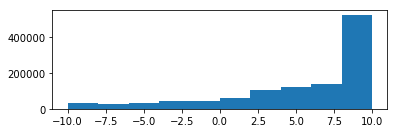

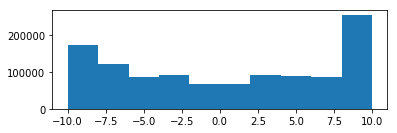

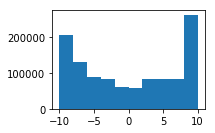

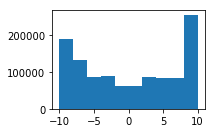

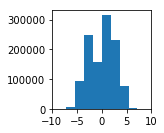

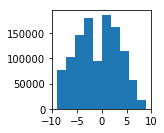

In [46]:
print(len(Q))
#checking Q value ranges are binned correctly
#range of velocity values when doing last two states, rounded to 10
bin1 = []
bin11 = []
bin12 = []
bin13 = []
bin2 = []
bin3 = []
for key,value in Q.items():
    bin1.append(key[1][0])
    bin11.append(key[1][1])
    bin12.append(key[1][2])
    bin13.append(key[1][3])
    bin2.append(key[1][4])
    bin3.append(key[1][5])
    #break
print(np.max(bin1),np.min(bin1))
print(np.max(bin11),np.min(bin11))
print(np.max(bin12),np.min(bin12))
print(np.max(bin13),np.min(bin13))
print(np.max(bin2),np.min(bin2))
print(np.max(bin3),np.min(bin3))

import matplotlib.pyplot as plt

plt.subplot(211)
#plt.plot(bin1,'.')
plt.hist(bin1)
plt.show()
plt.subplot(212)
#plt.plot(bin2,'.')
plt.hist(bin11)
plt.show()
plt.subplot(221)
#plt.plot(bin3,'.')
plt.hist(bin12)
plt.show()
plt.subplot(222)
plt.hist(bin13)
plt.show()
plt.subplot(231)
plt.hist(bin2)
plt.show()
plt.subplot(232)
plt.hist(bin3)
plt.show()

In [48]:
state = env.reset()
#env.render()
for i in range(10):
    state = env.reset()
    env.render()
    for j in range(500):
        _,action = get_max_state_action(Q,action_space,state,round_place)
        state,reward,done,_ = env.step(action)
        if done:
            print('episode done after {}'.format(j))
            break
        
env.render(close=True)

episode done after 499
episode done after 499
episode done after 499
episode done after 499
episode done after 499
episode done after 499
episode done after 499
episode done after 499
episode done after 499
episode done after 499


In [ ]:
#failed on 8.5 million reps too